<h1><a>PD Model with Monitoring</a></h1>

<h2><a id="index">Index</a></h2>

[1. Functions](#funcs)

[2. Read Data](#readdata)

[3. Exploratory Data Analysis](#exploredata)

[4. General Preprocessing](#generalpreprocessing)

[5. Data Cleaning and Missing Value Treatment](#missingvaluetreatment)

[6. PD model - Dependent Variable](#pddep)

[7. Data Preparation](#dataprep)

[8. Export to CSV File](#exportdata)

[9. Score New Data](#scorenewdata)

[10. PSI Calculations](#psicalc)

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
# Imports the libraries we need.
sns.set()

<h2><a id="funcs">1. Functions</a></h2>

[Index](#index)

In [2]:
# WoE function for discrete unordered variables
def woe_discrete(df, discrete_variabe_name, good_bad_variable_df):
    df = pd.concat([df[discrete_variabe_name], good_bad_variable_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df
# Here we combine all of the operations above in a function.
# The function takes 3 arguments: a dataframe, a string, and a dataframe. The function returns a dataframe as a result.

In [3]:
# Below we define a function that takes 2 arguments: a dataframe and a number.
# The number parameter has a default value of 0.
# This means that if we call the function and omit the number parameter, it will be executed with it having a value of 0.
# The function displays a graph.
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    # Turns the values of the column with index 0 to strings, makes an array from these strings,
    # and passes it to variable x.
    y = df_WoE['WoE']
    # Selects a column with label 'WoE' and passes it to variable y.
    plt.figure(figsize=(18, 6))
    # Sets the graph size to width 18 x height 6.
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    # Plots the datapoints with coordiantes variable x on the x-axis and variable y on the y-axis.
    # Sets the marker for each datapoint to a circle, the style line between the points to dashed, and the color to black.
    plt.xlabel(df_WoE.columns[0])
    # Names the x-axis with the name of the column with index 0.
    plt.ylabel('Weight of Evidence')
    # Names the y-axis 'Weight of Evidence'.
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    # Names the grapth 'Weight of Evidence by ' the name of the column with index 0.
    plt.xticks(rotation = rotation_of_x_axis_labels)
    # Rotates the labels of the x-axis a predefined number of degrees.

In [4]:
# WoE function for ordered discrete and continuous variables
def woe_ordered_continuous(df, discrete_variabe_name, good_bad_variable_df):
    df = pd.concat([df[discrete_variabe_name], good_bad_variable_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    #df = df.sort_values(['WoE'])
    #df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df
# Here we define a function similar to the one above, ...
# ... with one slight difference: we order the results by the values of a different column.
# The function takes 3 arguments: a dataframe, a string, and a dataframe. The function returns a dataframe as a result.

<h2><a id="readdata">2. Read Data</a></h2>

[Index](#index)

In [5]:
# Import Libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [6]:
# Import Train and Test Data.
loan_data_inputs_train = pd.read_csv('../Data/loan_data_inputs_train.csv', index_col = 0)
loan_data_targets_train = pd.read_csv('../Data/loan_data_targets_train.csv', index_col = 0)
loan_data_inputs_test = pd.read_csv('../Data/loan_data_inputs_test.csv', index_col = 0)
loan_data_targets_test = pd.read_csv('../Data/loan_data_targets_test.csv', index_col = 0)

In [7]:
# Here we import the new data.
loan_data_backup = pd.read_csv('../Data/loan_data_2015.csv')

In [8]:
loan_data = loan_data_backup.copy()

<h2><a id="exploredata">3. Exploratory Data Analysis</a></h2>

[Index](#index)

In [9]:
pd.options.display.max_columns = None
#pd.options.display.max_rows = None
# Sets the pandas dataframe options to display all columns/ rows.

In [10]:
loan_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,68444620,73334399,35000,35000,35000.0,60 months,11.99,778.38,C,C1,Foreign Service Officer,10+ years,MORTGAGE,128000.0,Source Verified,Dec-15,Issued,n,https://www.lendingclub.com/browse/loanDetail....,NaN,home_improvement,Home improvement,200xx,DC,6.46,0.0,Feb-90,0.0,46.0,NaN,17.0,0.0,14277,27.4,46.0,w,35000.0,35000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,Jan-16,Jan-16,0.0,56.0,1,INDIVIDUAL,NaN,NaN,NaN,0.0,321.0,146867.0,1.0,11.0,0.0,0.0,28.0,35367.0,49.3,0.0,1.0,5020.0,40.1,52200.0,1.0,4.0,0.0
1,68547583,73437441,8650,8650,8650.0,36 months,5.32,260.50,A,A1,Associate Consultant,< 1 year,MORTGAGE,100000.0,Not Verified,Dec-15,Issued,n,https://www.lendingclub.com/browse/loanDetail....,NaN,credit_card,Credit card refinancing,462xx,IN,7.28,0.0,Jul-01,0.0,NaN,NaN,15.0,0.0,7158,26.7,24.0,w,8650.0,8650.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,Jan-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,165450.0,0.0,1.0,1.0,1.0,11.0,24041.0,88.8,0.0,3.0,3081.0,57.9,26800.0,1.0,0.0,5.0
2,67849662,72708407,4225,4225,4225.0,36 months,14.85,146.16,C,C5,mechanic,5 years,RENT,35000.0,Source Verified,Dec-15,Issued,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,672xx,KS,15.22,2.0,Jul-11,0.0,18.0,NaN,6.0,0.0,1058,24.6,6.0,w,4225.0,4225.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,Jan-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,4888.0,0.0,1.0,0.0,0.0,47.0,3830.0,21.9,0.0,0.0,367.0,22.4,4300.0,0.0,0.0,0.0
3,68506885,73396712,10000,10000,10000.0,60 months,11.99,222.40,C,C1,CARDIOVASCULAR TECH,10+ years,RENT,42500.0,Not Verified,Dec-15,Issued,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,460xx,IN,31.04,0.0,Dec-98,1.0,NaN,NaN,10.0,0.0,5812,40.9,23.0,w,10000.0,10000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,Jan-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,41166.0,1.0,3.0,0.0,2.0,13.0,35354.0,75.5,1.0,1.0,3118.0,67.4,14200.0,1.0,1.0,1.0
4,68341763,72928789,20000,20000,20000.0,60 months,10.78,432.66,B,B4,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,Dec-15,Issued,n,https://www.lendingclub.com/browse/loanDetail....,NaN,home_improvement,NaN,605xx,IL,10.78,0.0,Aug-00,0.0,NaN,NaN,6.0,0.0,7869,56.2,18.0,w,20000.0,20000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,Jan-16,Dec-15,0.0,NaN,1,JOINT,71000.0,13.85,Not Verified,0.0,0.0,189699.0,0.0,1.0,0.0,4.0,19.0,10827.0,72.8,0.0,2.0,2081.0,64.7,14000.0,2.0,5.0,1.0


In [11]:
loan_data.info()
# Displays column names, complete (non-missing) cases per column, and datatype per column.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421094 entries, 0 to 421093
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           421094 non-null  int64  
 1   member_id                    421094 non-null  int64  
 2   loan_amnt                    421094 non-null  int64  
 3   funded_amnt                  421094 non-null  int64  
 4   funded_amnt_inv              421094 non-null  float64
 5   term                         421094 non-null  object 
 6   int_rate                     421094 non-null  float64
 7   installment                  421094 non-null  float64
 8   grade                        421094 non-null  object 
 9   sub_grade                    421094 non-null  object 
 10  emp_title                    397220 non-null  object 
 11  emp_length                   397277 non-null  object 
 12  home_ownership               421094 non-null  object 
 13 

<h2><a id="generalpreprocessing">4. General Preprocessing</a></h2>

[Index](#index)

[4.1 Continuous Variables](#precontvar)

[4.2 Discrete Variables](#prediscvar)

<h3><a id="precontvar">4.1 Continuous Variables</a></h3>

[Top](#generalpreprocessing)

[4.1.1 Employement Length](#emp_length)

[4.1.2 Earliest Credit Line](#earliest_cr_line)

[4.1.3 Term](#term)

[4.1.4 Issue Date](#issue_d_date)

<h4><a id="emp_length">4.1.1 Employement Length</a></h4>

[Top](#precontvar)

In [12]:
loan_data['emp_length'].unique()
# Displays unique values of a column.

array(['10+ years', '< 1 year', '5 years', '3 years', '4 years', nan,
       '2 years', '8 years', '9 years', '1 year', '6 years', '7 years'],
      dtype=object)

In [13]:
# We store the preprocessed ‘employment length’ variable in a new variable called ‘employment length int’,
loan_data['emp_length_int'] = loan_data['emp_length'].str.replace('\+ years', '')
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace('< 1 year', str(0))
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace('n/a',  str(0))
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace(' years', '')
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace(' year', '')

In [14]:
# Checks the datatype of a single element of a column.
type(loan_data['emp_length_int'][0])

str

In [15]:
# Transforms the values to numeric.
loan_data['emp_length_int'] = pd.to_numeric(loan_data['emp_length_int'])
# Checks the datatype of a single element of a column.
type(loan_data['emp_length_int'][0])


numpy.float64

<h4><a id="earliest_cr_line">4.1.2 Earliest Credit Line</a></h4>

[Top](#precontvar)

In [16]:
loan_data['earliest_cr_line'].head()

0    Feb-90
1    Jul-01
2    Jul-11
3    Dec-98
4    Aug-00
Name: earliest_cr_line, dtype: object

In [17]:
# Extracts the date and the time from a string variable that is in a given format.
loan_data['earliest_cr_line_date'] = pd.to_datetime(loan_data['earliest_cr_line'], format = '%b-%y')
# Checks the datatype of a single element of a column.
type(loan_data['earliest_cr_line_date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [18]:
# Assume we are now in December 2018
# We calculate the difference between two dates in months, turn it to numeric datatype and round it
loan_data['mths_since_earliest_cr_line'] = round(pd.to_numeric((pd.to_datetime('2018-12-01') - 
                                                                loan_data['earliest_cr_line_date']) /
                                                               np.timedelta64(1, 'M')))
loan_data['mths_since_earliest_cr_line'].describe()

count    421094.000000
mean        239.354876
std          98.123989
min        -600.000000
25%         179.000000
50%         224.000000
75%         289.000000
max         599.000000
Name: mths_since_earliest_cr_line, dtype: float64

In [19]:
# Display values where it is negative
loan_data.loc[: , ['earliest_cr_line', 'earliest_cr_line_date', 'mths_since_earliest_cr_line']][
    loan_data['mths_since_earliest_cr_line'] < 0]

,earliest_cr_line,earliest_cr_line_date,mths_since_earliest_cr_line
254,Jan-57,2057-01-01,-457.0
618,Aug-64,2064-08-01,-548.0
648,Jul-68,2068-07-01,-595.0
1808,Jan-65,2065-01-01,-553.0
2583,Sep-64,2064-09-01,-549.0
...,...,...,...
418890,Jun-68,2068-06-01,-594.0
420450,Jan-66,2066-01-01,-565.0
420642,Sep-68,2068-09-01,-597.0
420794,Sep-65,2065-09-01,-561.0


In [20]:
# We set the rows that had negative differences to the maximum value as these were taken in 1900s
loan_data['mths_since_earliest_cr_line'][loan_data['mths_since_earliest_cr_line'] < 0] = (
    loan_data['mths_since_earliest_cr_line'].max())
loan_data['mths_since_earliest_cr_line'].describe()

count    421094.000000
mean        242.471220
std          90.827636
min          73.000000
25%         180.000000
50%         224.000000
75%         290.000000
max         599.000000
Name: mths_since_earliest_cr_line, dtype: float64

<h4><a id="term">4.1.3 Term</a></h4>

[Top](#precontvar)

In [21]:
loan_data['term'].head()

0     60 months
1     36 months
2     36 months
3     60 months
4     60 months
Name: term, dtype: object

In [22]:
# We remplace a string from a variable with another string, in this case, with an empty strng (i.e. with nothing).
# We turn the result to numeric datatype and save it in another variable.
loan_data['term_int'] = pd.to_numeric(loan_data['term'].str.replace(' months', ''))
loan_data['term_int'].head()

0    60
1    36
2    36
3    60
4    60
Name: term_int, dtype: int64

In [23]:
# Checks the datatype of a single element of a column.
type(loan_data['term_int'][0])

numpy.int64

<h4><a id="issue_d_date">4.1.4 Issue Date</a></h4>

[Top](#precontvar)

In [24]:
# Assume we are now in December 2018
loan_data['issue_d_date'] = pd.to_datetime(loan_data['issue_d'], format = '%b-%y')
# Extracts the date and the time from a string variable that is in a given format.
loan_data['mths_since_issue_d'] = round(pd.to_numeric((pd.to_datetime('2018-12-01') - loan_data['issue_d_date']) / 
                                                      np.timedelta64(1, 'M')))
# We calculate the difference between two dates in months, turn it to numeric datatype and round it.
# We save the result in a new variable.
loan_data['mths_since_issue_d'].describe()

count    421094.000000
mean         41.044629
std           3.458162
min          36.000000
25%          38.000000
50%          41.000000
75%          44.000000
max          47.000000
Name: mths_since_issue_d, dtype: float64

<h3><a id="prediscvar">4.2 Discrete Variables</a></h3>

[Top](#generalpreprocessing)


We are going to preprocess the following discrete variables: grade, sub_grade, home_ownership, verification_status, loan_status, purpose, addr_state, initial_list_status. Most likely, we are not going to use sub_grade, as it overlaps with grade.


In [25]:
# We create dummy variables from all 8 original independent variables, and save them into a list.
# Note that we are using a particular naming convention for all variables: original variable name, colon, category name.
loan_data_dummies = [pd.get_dummies(loan_data['grade'], prefix = 'grade', prefix_sep = ':'),
                     pd.get_dummies(loan_data['sub_grade'], prefix = 'sub_grade', prefix_sep = ':'),
                     pd.get_dummies(loan_data['home_ownership'], prefix = 'home_ownership', prefix_sep = ':'),
                     pd.get_dummies(loan_data['verification_status'], prefix = 'verification_status', prefix_sep = ':'),
                     pd.get_dummies(loan_data['loan_status'], prefix = 'loan_status', prefix_sep = ':'),
                     pd.get_dummies(loan_data['purpose'], prefix = 'purpose', prefix_sep = ':'),
                     pd.get_dummies(loan_data['addr_state'], prefix = 'addr_state', prefix_sep = ':'),
                     pd.get_dummies(loan_data['initial_list_status'], prefix = 'initial_list_status', prefix_sep = ':')]

In [26]:
# We concatenate the dummy variables and this turns them into a dataframe.
loan_data_dummies = pd.concat(loan_data_dummies, axis = 1)

In [27]:
# Concatenates two dataframes.
# Here we concatenate the dataframe with original data with the dataframe with dummy variables, along the columns. 
loan_data = pd.concat([loan_data, loan_data_dummies], axis = 1)

<h2><a id="missingvaluetreatment">5. Data Cleaning and Missing Value Treatment</a></h2>

[Index](#index)

In [28]:
# Calculate null values
null_values = loan_data.isnull().sum()
null_values[null_values>0]

emp_title                       23874
emp_length                      23817
desc                           421049
title                             132
mths_since_last_delinq         203961
mths_since_last_record         346679
revol_util                        162
last_pymnt_d                    17283
next_pymnt_d                    25757
last_credit_pull_d                 11
mths_since_last_major_derog    298365
annual_inc_joint               420583
dti_joint                      420585
verification_status_joint      420583
open_acc_6m                    399722
open_il_6m                     399722
open_il_12m                    399722
open_il_24m                    399722
mths_since_rcnt_il             400284
total_bal_il                   399722
il_util                        402477
open_rv_12m                    399722
open_rv_24m                    399722
max_bal_bc                     399722
all_util                       399722
inq_fi                         399722
total_cu_tl 

In [29]:
# 'Total revolving high credit/ credit limit', so it makes sense that the missing values are equal to funded_amnt.
loan_data['total_rev_hi_lim'].fillna(loan_data['funded_amnt'], inplace=True)
loan_data['total_rev_hi_lim'].isnull().sum()

0

In [30]:
# We fill the missing values with the mean value of the non-missing values.
loan_data['annual_inc'].fillna(loan_data['annual_inc'].mean(), inplace=True)
loan_data['annual_inc'].isnull().sum()

0

In [31]:
# We fill the missing values with zeroes.
loan_data['mths_since_earliest_cr_line'].fillna(0, inplace=True)
loan_data['acc_now_delinq'].fillna(0, inplace=True)
loan_data['total_acc'].fillna(0, inplace=True)
loan_data['pub_rec'].fillna(0, inplace=True)
loan_data['open_acc'].fillna(0, inplace=True)
loan_data['inq_last_6mths'].fillna(0, inplace=True)
loan_data['delinq_2yrs'].fillna(0, inplace=True)
loan_data['emp_length_int'].fillna(0, inplace=True)

In [32]:
# Calculate null values
null_values = loan_data.isnull().sum()
null_values[null_values>0]

emp_title                       23874
emp_length                      23817
desc                           421049
title                             132
mths_since_last_delinq         203961
mths_since_last_record         346679
revol_util                        162
last_pymnt_d                    17283
next_pymnt_d                    25757
last_credit_pull_d                 11
mths_since_last_major_derog    298365
annual_inc_joint               420583
dti_joint                      420585
verification_status_joint      420583
open_acc_6m                    399722
open_il_6m                     399722
open_il_12m                    399722
open_il_24m                    399722
mths_since_rcnt_il             400284
total_bal_il                   399722
il_util                        402477
open_rv_12m                    399722
open_rv_24m                    399722
max_bal_bc                     399722
all_util                       399722
inq_fi                         399722
total_cu_tl 

<h2><a id="pddep">6. PD model - Dependent Variable</a></h2>

[Index](#index)

In [33]:
# Displays unique values of a column.
loan_data['loan_status'].unique()

array(['Issued', 'Current', 'Fully Paid', 'In Grace Period',
       'Late (16-30 days)', 'Late (31-120 days)', 'Charged Off',
       'Default'], dtype=object)

In [34]:
# Calculates the number of observations for each unique value of a variable.
loan_data['loan_status'].value_counts()

Current               377553
Fully Paid             22984
Issued                  8460
Late (31-120 days)      4691
In Grace Period         3107
Charged Off             2773
Late (16-30 days)       1139
Default                  387
Name: loan_status, dtype: int64

In [35]:
loan_data['loan_status'].value_counts(normalize=True)
# We divide the number of observations for each unique value of a variable by the total number of observations.
# Thus, we get the proportion of observations for each unique value of a variable.

Current               0.896600
Fully Paid            0.054582
Issued                0.020091
Late (31-120 days)    0.011140
In Grace Period       0.007378
Charged Off           0.006585
Late (16-30 days)     0.002705
Default               0.000919
Name: loan_status, dtype: float64

In [36]:
# Good/ Bad Definition
loan_data['good_bad'] = np.where(loan_data['loan_status'].isin(['Charged Off', 'Default',
                                                       'Does not meet the credit policy. Status:Charged Off',
                                                       'Late (31-120 days)']), 0, 1)
loan_data['good_bad'].value_counts(normalize=True)

1    0.981356
0    0.018644
Name: good_bad, dtype: float64

<h2><a id="dataprep">7. Data Preparation</a></h2>

[Index](#index)

[7.1 Discrete Variables](#discretewoewoe)

[7.2 Continuous Variables](#continuouswoe)

In [37]:
#####
df_inputs_prepr = loan_data.drop('good_bad', axis = 1)
df_targets_prepr = loan_data['good_bad']

<h3><a id="discretewoewoe">7.1 Discrete Variables</a></h3>

[Top](#dataprep)

[7.1.1 Grade](#gradewoe)

[7.1.2 Home Ownership](#homeownershipwoe)

[7.1.3 Address State](#addr_statewoe)

[7.1.4 Verification Status](#verifstatuswoe)

[7.1.5 Purpose](#purposewoe)

[7.1.6 Initial List Status](#initialliststatuswoe)

<h4><a id="gradewoe">7.1.1 Grade</a></h4>

[Top](#discretewoewoe)

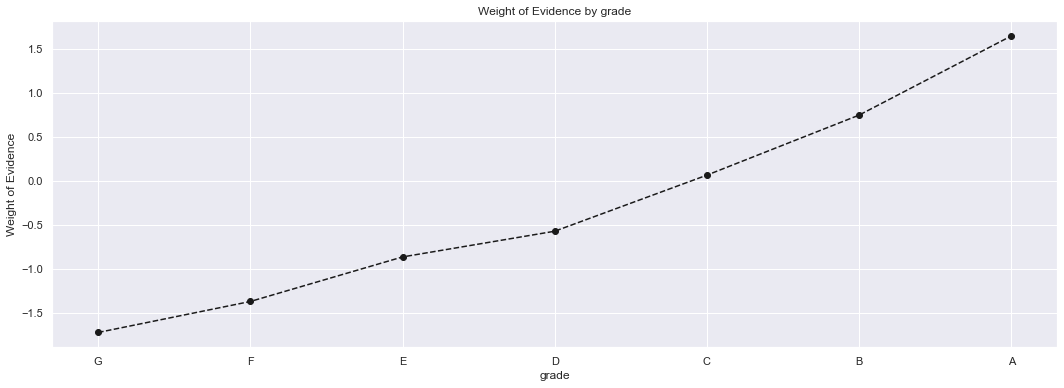

In [38]:
# 'grade'
df_temp = woe_discrete(df_inputs_prepr, 'grade', df_targets_prepr)
plot_by_woe(df_temp)

<h4><a id="homeownershipwoe">7.1.2 Home Ownership</a></h4>

[Top](#discretewoewoe)

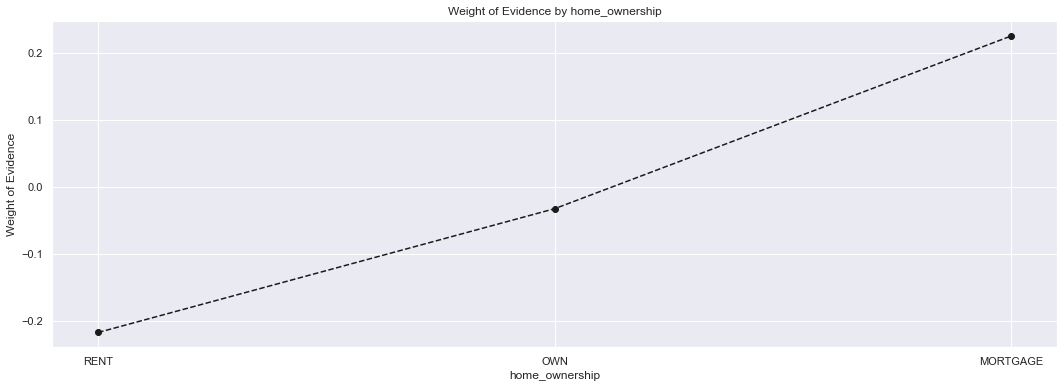

In [39]:
# 'home_ownership'
df_temp = woe_discrete(df_inputs_prepr, 'home_ownership', df_targets_prepr)
# We calculate weight of evidence.
plot_by_woe(df_temp)

In [40]:
# There are many categories with very few observations and many categories with very different "good" %.
# Therefore, we create a new discrete variable where we combine some of the categories.
# 'OTHERS' and 'NONE' are riskiest but are very few. 'RENT' is the next riskiest.
# 'ANY' are least risky but are too few. Conceptually, they belong to the same category. 
# Also, their inclusion would not change anything.
# We combine them in one category, 'RENT_OTHER_NONE_ANY'.
# We end up with 3 categories: 'RENT_OTHER_NONE_ANY', 'OWN', 'MORTGAGE'.
df_inputs_prepr['home_ownership:RENT_OTHER_NONE_ANY'] = sum([df_inputs_prepr['home_ownership:RENT'],
                                                             df_inputs_prepr['home_ownership:ANY']])
# 'RENT_OTHER_NONE_ANY' will be the reference category.

<h4><a id="addr_statewoe">7.1.3 Address State</a></h4>

[Top](#discretewoewoe)

In [41]:
# 'addr_state'
df_inputs_prepr['addr_state'].unique()

array(['DC', 'IN', 'KS', 'IL', 'OR', 'VA', 'PA', 'GA', 'TN', 'OH', 'NY',
       'FL', 'NJ', 'RI', 'NC', 'AL', 'TX', 'SC', 'MD', 'WA', 'MO', 'MN',
       'NH', 'VT', 'AZ', 'MI', 'MA', 'CA', 'LA', 'DE', 'NM', 'CO', 'WI',
       'SD', 'CT', 'NE', 'HI', 'AR', 'MT', 'WV', 'WY', 'OK', 'NV', 'KY',
       'MS', 'ME', 'UT', 'ND', 'AK'], dtype=object)

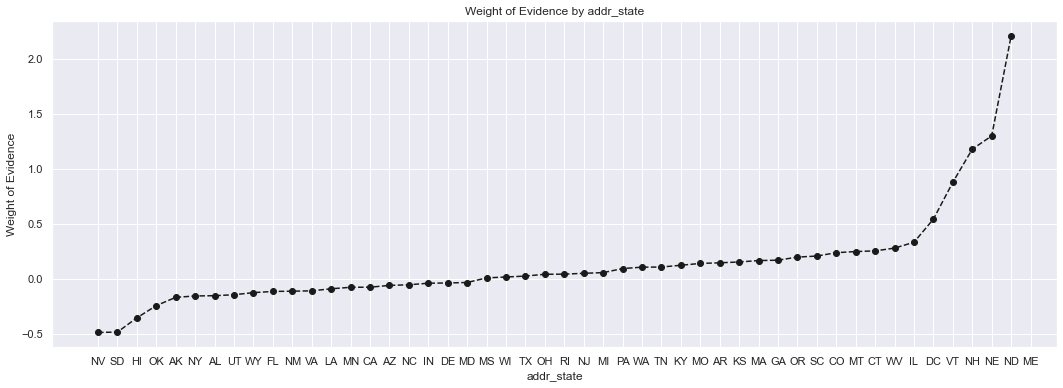

In [42]:
df_temp = woe_discrete(df_inputs_prepr, 'addr_state', df_targets_prepr)
# We calculate weight of evidence.
plot_by_woe(df_temp)

In [43]:
if ['addr_state:ND'] in df_inputs_prepr.columns.values:
    pass
else:
    df_inputs_prepr['addr_state:ND'] = 0

In [44]:
if ['addr_state:ID'] in df_inputs_prepr.columns.values:
    pass
else:
    df_inputs_prepr['addr_state:ID'] = 0

In [45]:
if ['addr_state:IA'] in df_inputs_prepr.columns.values:
    pass
else:
    df_inputs_prepr['addr_state:IA'] = 0

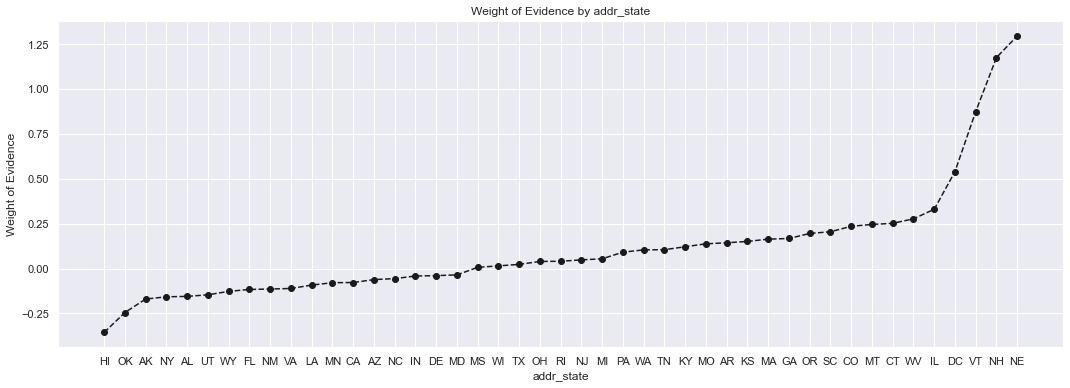

In [46]:
plot_by_woe(df_temp.iloc[2: -2, : ])
# We plot the weight of evidence values.

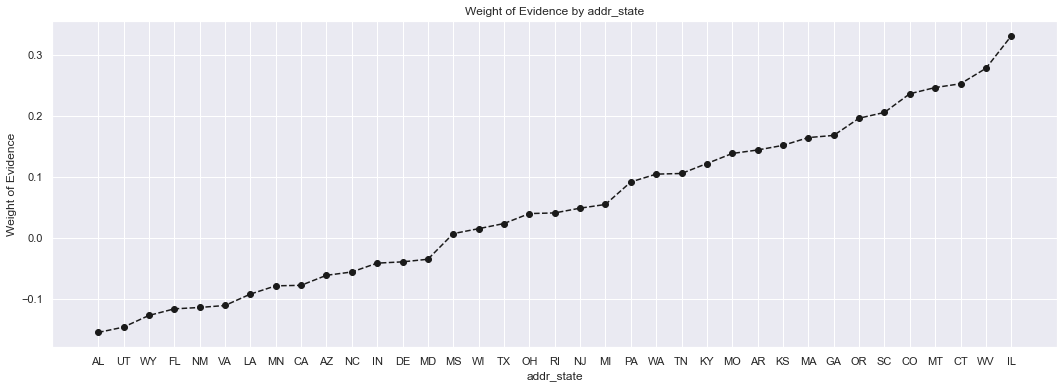

In [47]:
plot_by_woe(df_temp.iloc[6: -6, : ])
# We plot the weight of evidence values.

In [48]:
# We create the following categories:
# 'ND' 'NE' 'IA' NV' 'FL' 'HI' 'AL'
# 'NM' 'VA'
# 'NY'
# 'OK' 'TN' 'MO' 'LA' 'MD' 'NC'
# 'CA'
# 'UT' 'KY' 'AZ' 'NJ'
# 'AR' 'MI' 'PA' 'OH' 'MN'
# 'RI' 'MA' 'DE' 'SD' 'IN'
# 'GA' 'WA' 'OR'
# 'WI' 'MT'
# 'TX'
# 'IL' 'CT'
# 'KS' 'SC' 'CO' 'VT' 'AK' 'MS'
# 'WV' 'NH' 'WY' 'DC' 'ME' 'ID'

# 'IA_NV_HI_ID_AL_FL' will be the reference category.

df_inputs_prepr['addr_state:ND_NE_IA_NV_FL_HI_AL'] = sum([df_inputs_prepr['addr_state:ND'], 
                                                          df_inputs_prepr['addr_state:NE'], 
                                                          df_inputs_prepr['addr_state:IA'],
                                                          df_inputs_prepr['addr_state:NV'],
                                                          df_inputs_prepr['addr_state:FL'], 
                                                          df_inputs_prepr['addr_state:HI'],
                                                          df_inputs_prepr['addr_state:AL']])

df_inputs_prepr['addr_state:NM_VA'] = sum([df_inputs_prepr['addr_state:NM'], df_inputs_prepr['addr_state:VA']])

df_inputs_prepr['addr_state:OK_TN_MO_LA_MD_NC'] = sum([df_inputs_prepr['addr_state:OK'], df_inputs_prepr['addr_state:TN'],
                                              df_inputs_prepr['addr_state:MO'], df_inputs_prepr['addr_state:LA'],
                                              df_inputs_prepr['addr_state:MD'], df_inputs_prepr['addr_state:NC']])

df_inputs_prepr['addr_state:UT_KY_AZ_NJ'] = sum([df_inputs_prepr['addr_state:UT'], df_inputs_prepr['addr_state:KY'],
                                              df_inputs_prepr['addr_state:AZ'], df_inputs_prepr['addr_state:NJ']])

df_inputs_prepr['addr_state:AR_MI_PA_OH_MN'] = sum([df_inputs_prepr['addr_state:AR'], df_inputs_prepr['addr_state:MI'],
                                              df_inputs_prepr['addr_state:PA'], df_inputs_prepr['addr_state:OH'],
                                              df_inputs_prepr['addr_state:MN']])

df_inputs_prepr['addr_state:RI_MA_DE_SD_IN'] = sum([df_inputs_prepr['addr_state:RI'], df_inputs_prepr['addr_state:MA'],
                                              df_inputs_prepr['addr_state:DE'], df_inputs_prepr['addr_state:SD'],
                                              df_inputs_prepr['addr_state:IN']])

df_inputs_prepr['addr_state:GA_WA_OR'] = sum([df_inputs_prepr['addr_state:GA'], df_inputs_prepr['addr_state:WA'],
                                              df_inputs_prepr['addr_state:OR']])

df_inputs_prepr['addr_state:WI_MT'] = sum([df_inputs_prepr['addr_state:WI'], df_inputs_prepr['addr_state:MT']])

df_inputs_prepr['addr_state:IL_CT'] = sum([df_inputs_prepr['addr_state:IL'], df_inputs_prepr['addr_state:CT']])

df_inputs_prepr['addr_state:KS_SC_CO_VT_AK_MS'] = sum([df_inputs_prepr['addr_state:KS'], df_inputs_prepr['addr_state:SC'],
                                              df_inputs_prepr['addr_state:CO'], df_inputs_prepr['addr_state:VT'],
                                              df_inputs_prepr['addr_state:AK'], df_inputs_prepr['addr_state:MS']])

df_inputs_prepr['addr_state:WV_NH_WY_DC_ME_ID'] = sum([df_inputs_prepr['addr_state:WV'], df_inputs_prepr['addr_state:NH'],
                                              df_inputs_prepr['addr_state:WY'], df_inputs_prepr['addr_state:DC'],
                                              df_inputs_prepr['addr_state:ME'], df_inputs_prepr['addr_state:ID']])

<h4><a id="verifstatuswoe">7.1.4 Verification Status</a></h4>

[Top](#discretewoewoe)

### Preprocessing Discrete Variables: Homework

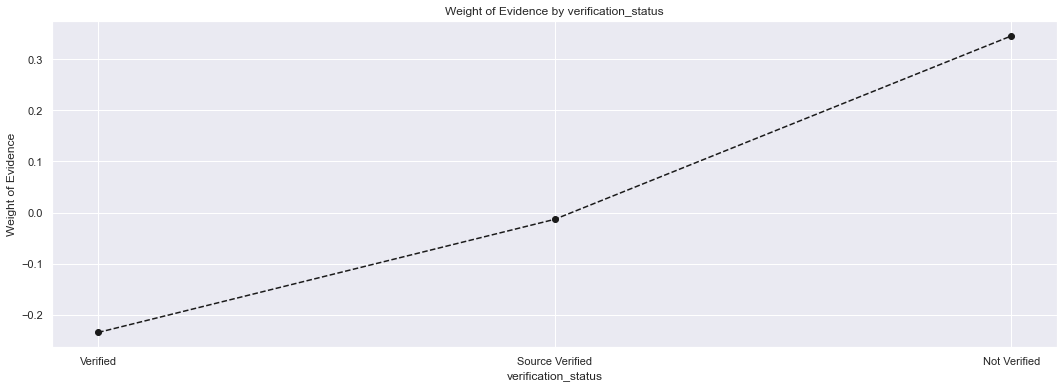

In [49]:
# 'verification_status'
df_temp = woe_discrete(df_inputs_prepr, 'verification_status', df_targets_prepr)
# We calculate weight of evidence.
plot_by_woe(df_temp)

<h4><a id="purposewoe">7.1.5 Purpose</a></h4>

[Top](#discretewoewoe)

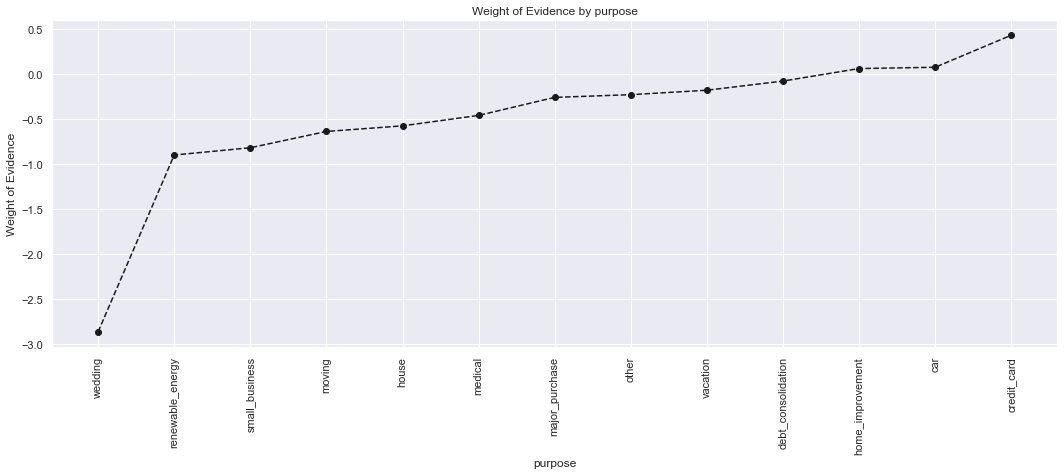

In [50]:
# 'purpose'
df_temp = woe_discrete(df_inputs_prepr, 'purpose', df_targets_prepr)
# We calculate weight of evidence.
plot_by_woe(df_temp, 90)

In [51]:
# We combine 'educational', 'small_business', 'wedding', 'renewable_energy', 'moving',
# 'house' in one category: 'educ__sm_b__wedd__ren_en__mov__house'.
# We combine 'other', 'medical', 'vacation' in one category: 'oth__med__vacation'.
# We combine 'major_purchase', 'car', 'home_improvement' in one category: 'major_purch__car__home_impr'.
# We leave 'debt_consolidtion' in a separate category.
# We leave 'credit_card' in a separate category.
# 'educ__sm_b__wedd__ren_en__mov__house' will be the reference category.
df_inputs_prepr['purpose:educ__sm_b__wedd__ren_en__mov__house'] = sum([df_inputs_prepr['purpose:educational'],
                                                                       df_inputs_prepr['purpose:small_business'], 
                                                                       df_inputs_prepr['purpose:wedding'],
                                                                       df_inputs_prepr['purpose:renewable_energy'], 
                                                                       df_inputs_prepr['purpose:moving'], 
                                                                       df_inputs_prepr['purpose:house']])
df_inputs_prepr['purpose:oth__med__vacation'] = sum([df_inputs_prepr['purpose:other'],
                                                     df_inputs_prepr['purpose:medical'],
                                                     df_inputs_prepr['purpose:vacation']])
df_inputs_prepr['purpose:major_purch__car__home_impr'] = sum([df_inputs_prepr['purpose:major_purchase'],
                                                              df_inputs_prepr['purpose:car'],
                                                              df_inputs_prepr['purpose:home_improvement']])

<h4><a id="initialliststatuswoe">7.1.6 Initial List Status</a></h4>

[Top](#discretewoewoe)

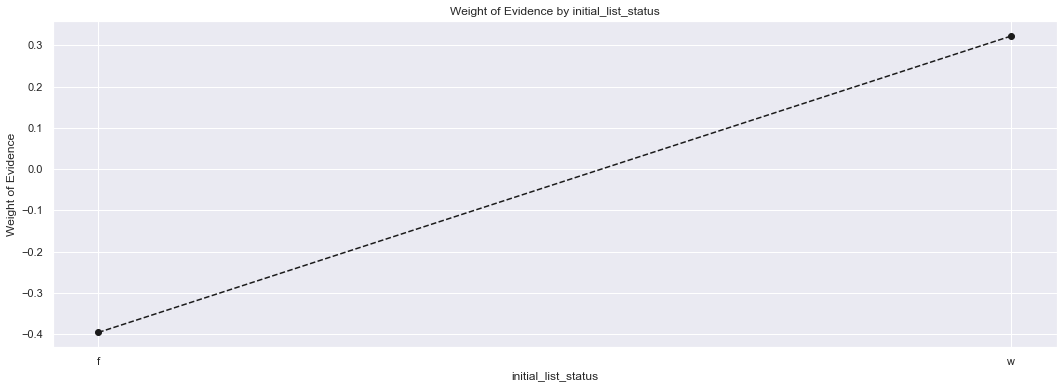

In [52]:
# 'initial_list_status'
df_temp = woe_discrete(df_inputs_prepr, 'initial_list_status', df_targets_prepr)
plot_by_woe(df_temp)

<h3><a id="continuouswoe">7.2 Continuous Variables</a></h3>

[Top](#dataprep)

[7.2.1 Term Int](#term_int_woe)

[7.2.2 Employment Lenght](#employmentlenght_woe)

[7.2.3 Months Since Issue](#monthssinceissued_woe)

[7.2.4 Interest Rate Factor](#int_rate_factor_woe)

[7.2.5 Funded Amount Factor](#funded_amnt_factor_woe)

[7.2.6 Months Since Last Credit Line](#mths_since_earliest_cr_line_factor_woe)

[7.2.7 Deliquency in Last 2 Years](#delinq_2yrs_woe)

[7.2.8 Credit Inquiries in Last 6 months](#inq_last_6mths_woe)

[7.2.9 Open Accounts](#open_acc_woe)

[7.2.10 Derogatory Public Records (bankruptcy filings, tax liens, or judgments](#pub_rec_woe)

[7.2.11 Total Accounts](#total_acc_woe)

[7.2.12 Accounts Deliquents](#acc_now_delinq_woe)

[7.2.13 Total Revolving Credit Limit](#total_rev_hi_lim_woe)

[7.2.14 Installment Factor](#installment_factor_woe)

[7.2.15 Annual Income](#annual_inc_factor_woe)

[7.2.16 Months Since Last Delinquency](#mths_since_last_delinq_woe)

[7.2.17 Debt to Income Ratio](#dti_factor_woe)

[7.2.18 Months Since Last Record](#mths_since_last_record_woe)

<h4><a id="term_int_woe">7.2.1 Term Int</a></h4>

[Top](#continuouswoe)

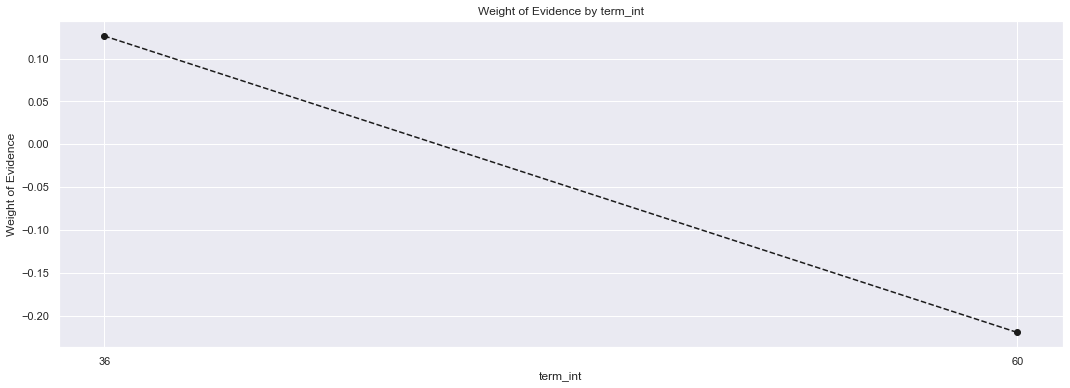

In [53]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'term_int', df_targets_prepr)
# We calculate weight of evidence.
plot_by_woe(df_temp)

In [54]:
# Leave as is.
# '60' will be the reference category.
df_inputs_prepr['term:36'] = np.where((df_inputs_prepr['term_int'] == 36), 1, 0)
df_inputs_prepr['term:60'] = np.where((df_inputs_prepr['term_int'] == 60), 1, 0)

<h4><a id="employmentlenght_woe">7.2.2 Employment Length</a></h4>

[Top](#continuouswoe)

In [55]:
# emp_length_int
df_inputs_prepr['emp_length_int'].unique()
# Has only 11 levels: from 0 to 10. Hence, we turn it into a factor with 11 levels.

array([10.,  0.,  5.,  3.,  4.,  2.,  8.,  9.,  1.,  6.,  7.])

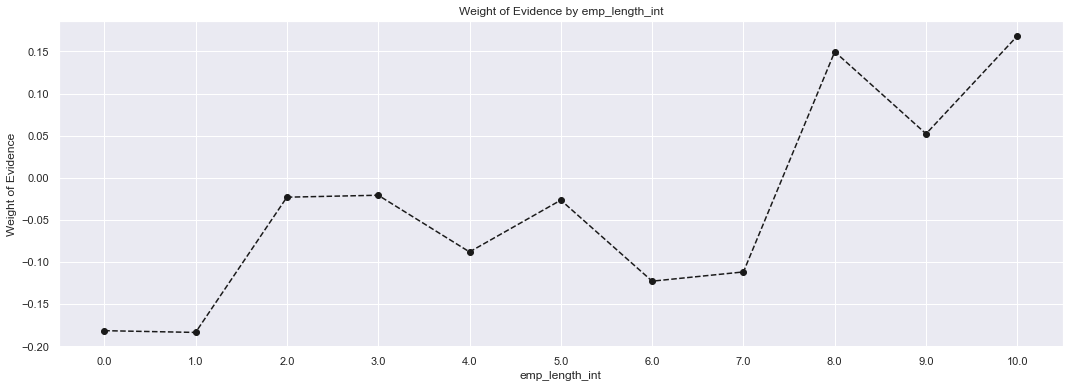

In [56]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'emp_length_int', df_targets_prepr)
# We calculate weight of evidence.
plot_by_woe(df_temp)

In [57]:
# We create the following categories: '0', '1', '2 - 4', '5 - 6', '7 - 9', '10'
# '0' will be the reference category
df_inputs_prepr['emp_length:0'] = np.where(df_inputs_prepr['emp_length_int'].isin([0]), 1, 0)
df_inputs_prepr['emp_length:1'] = np.where(df_inputs_prepr['emp_length_int'].isin([1]), 1, 0)
df_inputs_prepr['emp_length:2-4'] = np.where(df_inputs_prepr['emp_length_int'].isin(range(2, 5)), 1, 0)
df_inputs_prepr['emp_length:5-6'] = np.where(df_inputs_prepr['emp_length_int'].isin(range(5, 7)), 1, 0)
df_inputs_prepr['emp_length:7-9'] = np.where(df_inputs_prepr['emp_length_int'].isin(range(7, 10)), 1, 0)
df_inputs_prepr['emp_length:10'] = np.where(df_inputs_prepr['emp_length_int'].isin([10]), 1, 0)

<h4><a id="monthssinceissued_woe">7.2.3 Months Since Issue</a></h4>

[Top](#continuouswoe)

In [58]:
df_inputs_prepr['mths_since_issue_d'].unique()

array([36., 37., 38., 39., 40., 41., 42., 43., 44., 45., 46., 47.])

In [59]:
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_inputs_prepr['mths_since_issue_d_factor'] = pd.cut(df_inputs_prepr['mths_since_issue_d'], 50)
df_inputs_prepr['mths_since_issue_d_factor']

0         (35.989, 36.22]
1         (35.989, 36.22]
2         (35.989, 36.22]
3         (35.989, 36.22]
4         (35.989, 36.22]
               ...       
421089      (46.78, 47.0]
421090      (46.78, 47.0]
421091      (46.78, 47.0]
421092      (46.78, 47.0]
421093      (46.78, 47.0]
Name: mths_since_issue_d_factor, Length: 421094, dtype: category
Categories (50, interval[float64, right]): [(35.989, 36.22] < (36.22, 36.44] < (36.44, 36.66] < (36.66, 36.88] ... (46.12, 46.34] < (46.34, 46.56] < (46.56, 46.78] < (46.78, 47.0]]

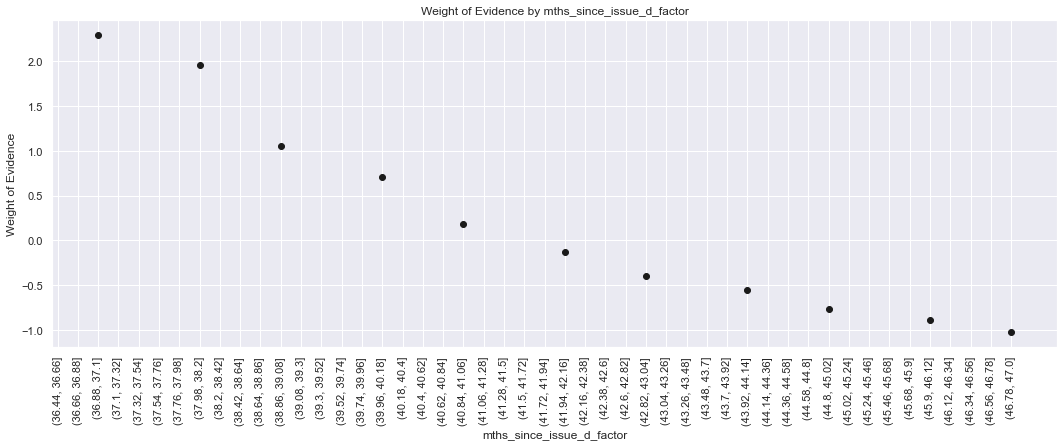

In [60]:
# mths_since_issue_d
df_temp = woe_ordered_continuous(df_inputs_prepr, 'mths_since_issue_d_factor', df_targets_prepr)
# We calculate weight of evidence.
plot_by_woe(df_temp, 90)

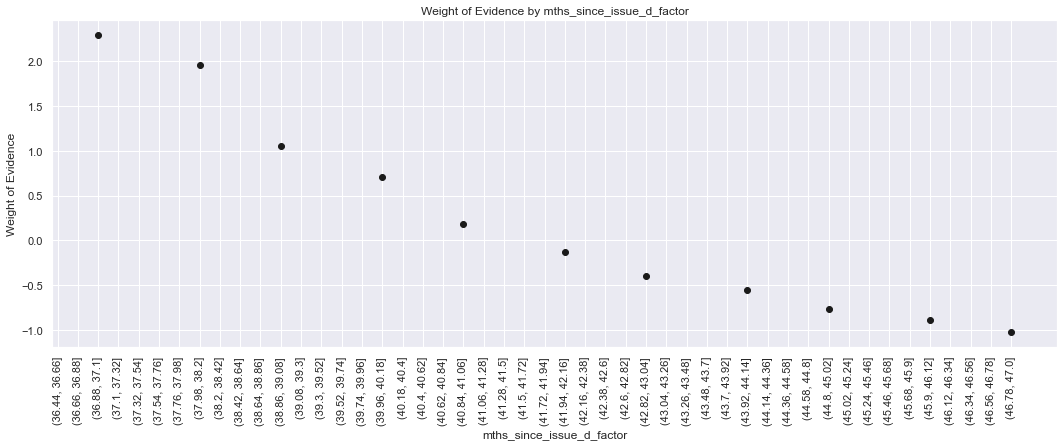

In [61]:
plot_by_woe(df_temp, 90)
# We plot the weight of evidence values, rotating the labels 90 degrees.

In [62]:
# We create the following categories:
# < 38, 38 - 39, 40 - 41, 42 - 48, 49 - 52, 53 - 64, 65 - 84, > 84.
df_inputs_prepr['mths_since_issue_d:<38'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(38)), 1, 0)
df_inputs_prepr['mths_since_issue_d:38-39'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(38, 40)), 1, 0)
df_inputs_prepr['mths_since_issue_d:40-41'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(40, 42)), 1, 0)
df_inputs_prepr['mths_since_issue_d:42-48'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(42, 49)), 1, 0)
df_inputs_prepr['mths_since_issue_d:49-52'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(49, 53)), 1, 0)
df_inputs_prepr['mths_since_issue_d:53-64'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(53, 65)), 1, 0)
df_inputs_prepr['mths_since_issue_d:65-84'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(65, 85)), 1, 0)
df_inputs_prepr['mths_since_issue_d:>84'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(
    range(85, int(df_inputs_prepr['mths_since_issue_d'].max()))), 1, 0)

<h4><a id="int_rate_factor_woe">7.2.4 Interest Rate Factor</a></h4>

[Top](#continuouswoe)

In [63]:
# int_rate
df_inputs_prepr['int_rate_factor'] = pd.cut(df_inputs_prepr['int_rate'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.

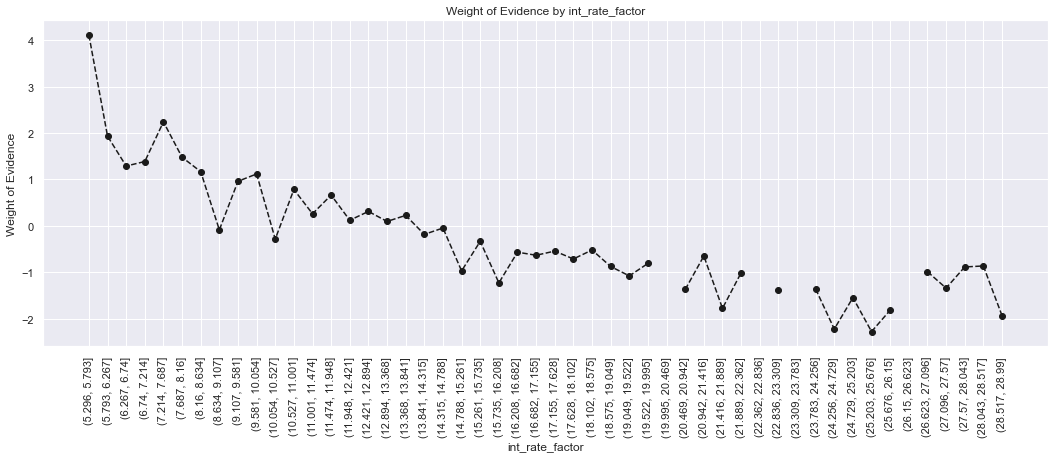

In [64]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'int_rate_factor', df_targets_prepr)
# We calculate weight of evidence.
plot_by_woe(df_temp, 90)

In [65]:
df_inputs_prepr['int_rate:<9.548'] = np.where((df_inputs_prepr['int_rate'] <= 9.548), 1, 0)
df_inputs_prepr['int_rate:9.548-12.025'] = np.where((df_inputs_prepr['int_rate'] > 9.548) & 
                                                    (df_inputs_prepr['int_rate'] <= 12.025), 1, 0)
df_inputs_prepr['int_rate:12.025-15.74'] = np.where((df_inputs_prepr['int_rate'] > 12.025) & 
                                                    (df_inputs_prepr['int_rate'] <= 15.74), 1, 0)
df_inputs_prepr['int_rate:15.74-20.281'] = np.where((df_inputs_prepr['int_rate'] > 15.74) & 
                                                    (df_inputs_prepr['int_rate'] <= 20.281), 1, 0)
df_inputs_prepr['int_rate:>20.281'] = np.where((df_inputs_prepr['int_rate'] > 20.281), 1, 0)

<h4><a id="funded_amnt_factor_woe">7.2.5 Funded Amount Factor</a></h4>

[Top](#continuouswoe)

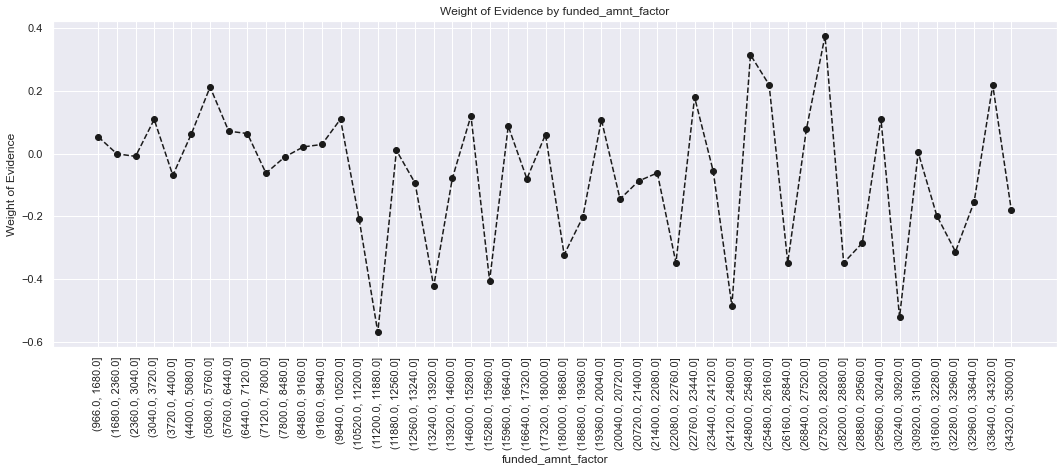

In [66]:
# funded_amnt
df_inputs_prepr['funded_amnt_factor'] = pd.cut(df_inputs_prepr['funded_amnt'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr, 'funded_amnt_factor', df_targets_prepr)
# We calculate weight of evidence.
plot_by_woe(df_temp, 90)

<h4><a id="mths_since_earliest_cr_line_factor_woe">7.2.6 Months Since Last Credit Line</a></h4>

[Top](#continuouswoe)

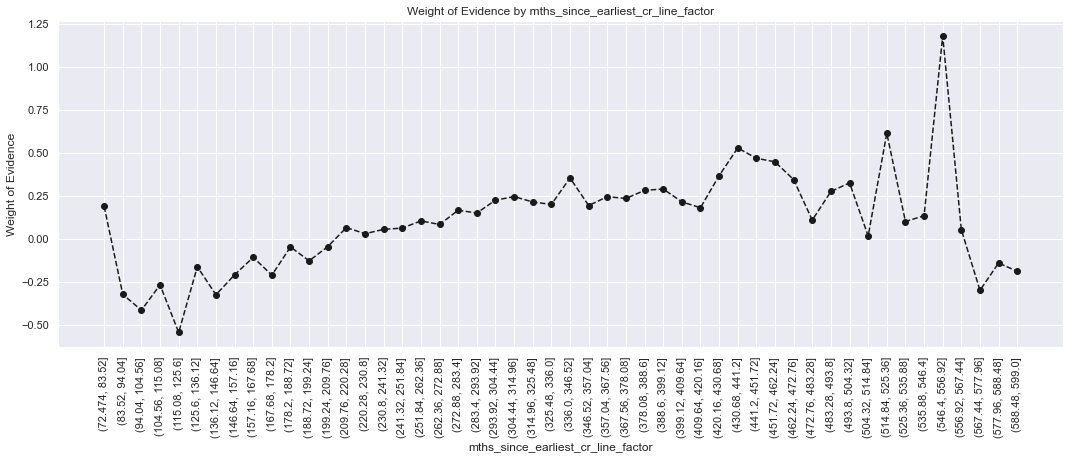

In [67]:
# mths_since_earliest_cr_line
df_inputs_prepr['mths_since_earliest_cr_line_factor'] = pd.cut(df_inputs_prepr['mths_since_earliest_cr_line'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr, 'mths_since_earliest_cr_line_factor', df_targets_prepr)
# We calculate weight of evidence.
plot_by_woe(df_temp, 90)

In [68]:
# We create the following categories:
# < 140, # 141 - 164, # 165 - 247, # 248 - 270, # 271 - 352, # > 352
df_inputs_prepr['mths_since_earliest_cr_line:<140'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(
    range(140)), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line:141-164'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(
    range(140, 165)), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line:165-247'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(
    range(165, 248)), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line:248-270'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(
    range(248, 271)), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line:271-352'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(
    range(271, 353)), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line:>352'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(
    range(353, int(df_inputs_prepr['mths_since_earliest_cr_line'].max()))), 1, 0)

<h4><a id="delinq_2yrs_woe">7.2.7 Deliquency in Last 2 Years</a></h4>

[Top](#continuouswoe)

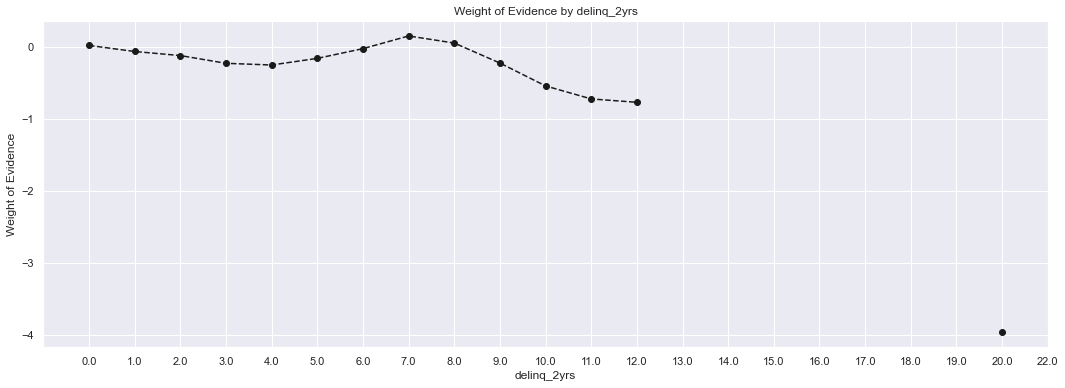

In [69]:
# delinq_2yrs
df_temp = woe_ordered_continuous(df_inputs_prepr, 'delinq_2yrs', df_targets_prepr)
# We calculate weight of evidence.
plot_by_woe(df_temp)

In [70]:
# Categories: 0, 1-3, >=4
df_inputs_prepr['delinq_2yrs:0'] = np.where((df_inputs_prepr['delinq_2yrs'] == 0), 1, 0)
df_inputs_prepr['delinq_2yrs:1-3'] = np.where((df_inputs_prepr['delinq_2yrs'] >= 1) & 
                                              (df_inputs_prepr['delinq_2yrs'] <= 3), 1, 0)
df_inputs_prepr['delinq_2yrs:>=4'] = np.where((df_inputs_prepr['delinq_2yrs'] >= 9), 1, 0)

<h4><a id="inq_last_6mths_woe">7.2.8 Credit Inquiries in Last 6 months</a></h4>

[Top](#continuouswoe)

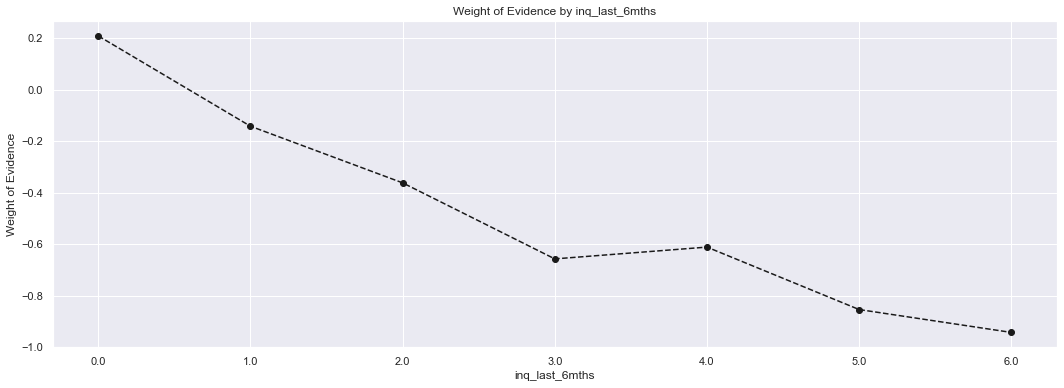

In [71]:
# inq_last_6mths
df_temp = woe_ordered_continuous(df_inputs_prepr, 'inq_last_6mths', df_targets_prepr)
# We calculate weight of evidence.
plot_by_woe(df_temp)

In [72]:
# Categories: 0, 1 - 2, 3 - 6, > 6
df_inputs_prepr['inq_last_6mths:0'] = np.where((df_inputs_prepr['inq_last_6mths'] == 0), 1, 0)
df_inputs_prepr['inq_last_6mths:1-2'] = np.where((df_inputs_prepr['inq_last_6mths'] >= 1) & 
                                                 (df_inputs_prepr['inq_last_6mths'] <= 2), 1, 0)
df_inputs_prepr['inq_last_6mths:3-6'] = np.where((df_inputs_prepr['inq_last_6mths'] >= 3) & 
                                                 (df_inputs_prepr['inq_last_6mths'] <= 6), 1, 0)
df_inputs_prepr['inq_last_6mths:>6'] = np.where((df_inputs_prepr['inq_last_6mths'] > 6), 1, 0)

<h4><a id="open_acc_woe">7.2.9 Open Accounts</a></h4>

[Top](#continuouswoe)

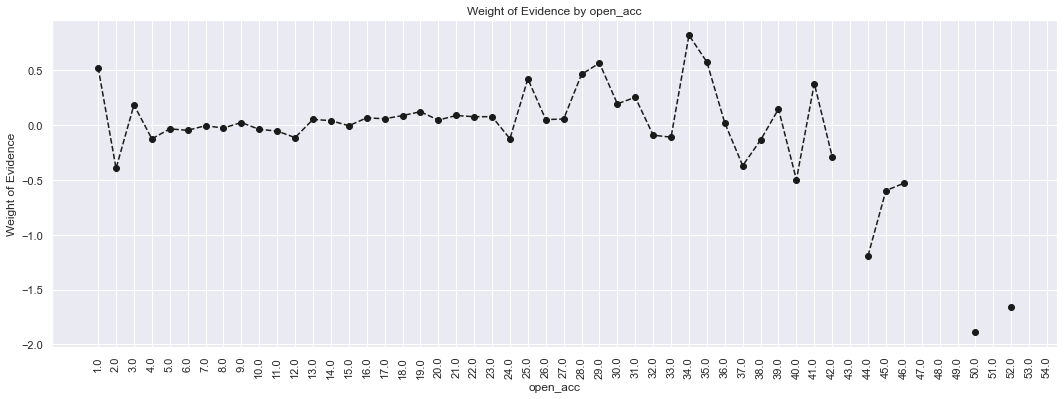

In [73]:
# open_acc
df_temp = woe_ordered_continuous(df_inputs_prepr, 'open_acc', df_targets_prepr)
# We calculate weight of evidence.
plot_by_woe(df_temp, 90)

In [74]:
# Categories: '0', '1-3', '4-12', '13-17', '18-22', '23-25', '26-30', '>30'
df_inputs_prepr['open_acc:0'] = np.where((df_inputs_prepr['open_acc'] == 0), 1, 0)
df_inputs_prepr['open_acc:1-3'] = np.where((df_inputs_prepr['open_acc'] >= 1) & (df_inputs_prepr['open_acc'] <= 3), 1, 0)
df_inputs_prepr['open_acc:4-12'] = np.where((df_inputs_prepr['open_acc'] >= 4) & 
                                            (df_inputs_prepr['open_acc'] <= 12), 1, 0)
df_inputs_prepr['open_acc:13-17'] = np.where((df_inputs_prepr['open_acc'] >= 13) & 
                                             (df_inputs_prepr['open_acc'] <= 17), 1, 0)
df_inputs_prepr['open_acc:18-22'] = np.where((df_inputs_prepr['open_acc'] >= 18) & 
                                             (df_inputs_prepr['open_acc'] <= 22), 1, 0)
df_inputs_prepr['open_acc:23-25'] = np.where((df_inputs_prepr['open_acc'] >= 23) & 
                                             (df_inputs_prepr['open_acc'] <= 25), 1, 0)
df_inputs_prepr['open_acc:26-30'] = np.where((df_inputs_prepr['open_acc'] >= 26) & 
                                             (df_inputs_prepr['open_acc'] <= 30), 1, 0)
df_inputs_prepr['open_acc:>=31'] = np.where((df_inputs_prepr['open_acc'] >= 31), 1, 0)

<h4><a id="pub_rec_woe">7.2.10 Derogatory Public Records (bankruptcy filings, tax liens, or judgments)</a></h4>

[Top](#continuouswoe)

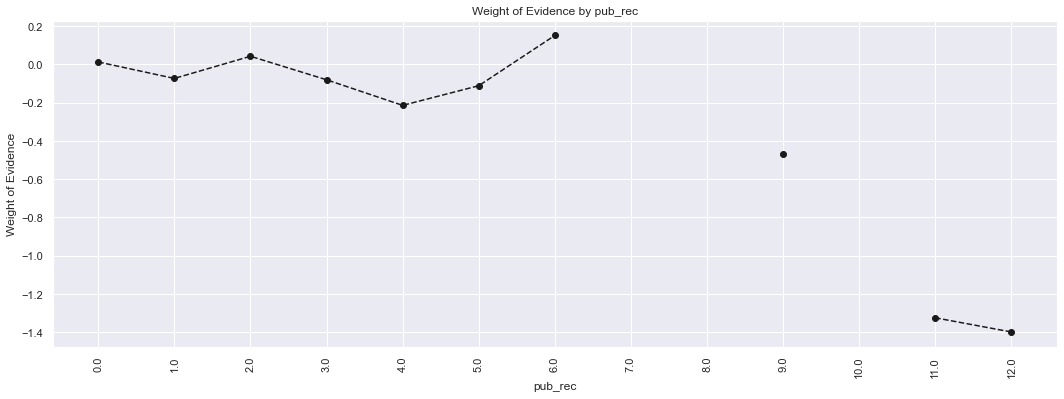

In [75]:
# pub_rec
df_temp = woe_ordered_continuous(df_inputs_prepr, 'pub_rec', df_targets_prepr)
# We calculate weight of evidence.
plot_by_woe(df_temp, 90)

In [76]:
# Categories '0-2', '3-4', '>=5'
df_inputs_prepr['pub_rec:0-2'] = np.where((df_inputs_prepr['pub_rec'] >= 0) & (df_inputs_prepr['pub_rec'] <= 2), 1, 0)
df_inputs_prepr['pub_rec:3-4'] = np.where((df_inputs_prepr['pub_rec'] >= 3) & (df_inputs_prepr['pub_rec'] <= 4), 1, 0)
df_inputs_prepr['pub_rec:>=5'] = np.where((df_inputs_prepr['pub_rec'] >= 5), 1, 0)

<h4><a id="total_acc_woe">7.2.11 Total Accounts</a></h4>

[Top](#continuouswoe)

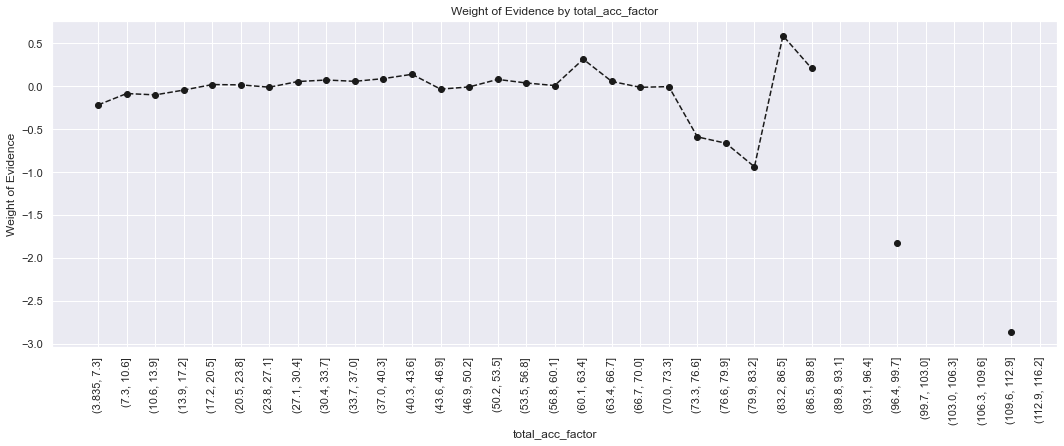

In [77]:
# total_acc
df_inputs_prepr['total_acc_factor'] = pd.cut(df_inputs_prepr['total_acc'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr, 'total_acc_factor', df_targets_prepr)
# We calculate weight of evidence.
plot_by_woe(df_temp, 90)

In [78]:
# Categories: '<=27', '28-51', '>51'
df_inputs_prepr['total_acc:<=27'] = np.where((df_inputs_prepr['total_acc'] <= 27), 1, 0)
df_inputs_prepr['total_acc:28-51'] = np.where((df_inputs_prepr['total_acc'] >= 28) & 
                                              (df_inputs_prepr['total_acc'] <= 51), 1, 0)
df_inputs_prepr['total_acc:>=52'] = np.where((df_inputs_prepr['total_acc'] >= 52), 1, 0)

<h4><a id="acc_now_delinq_woe">7.2.12 Accounts Deliquents</a></h4>

[Top](#continuouswoe)

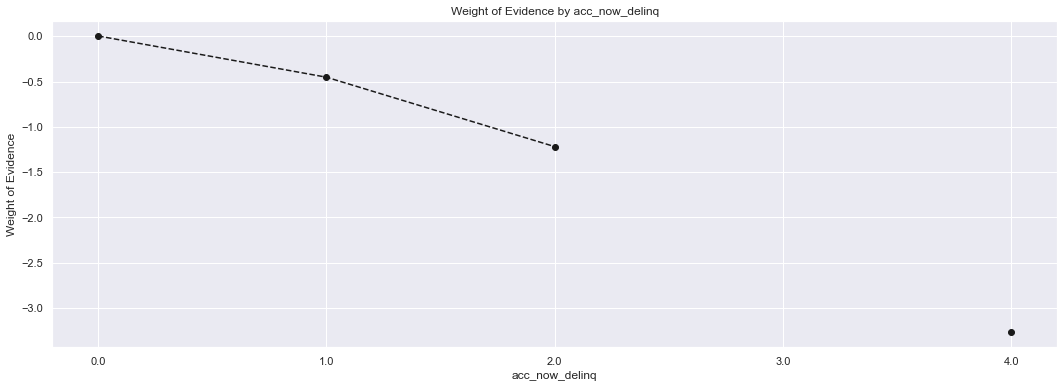

In [79]:
# acc_now_delinq
df_temp = woe_ordered_continuous(df_inputs_prepr, 'acc_now_delinq', df_targets_prepr)
# We calculate weight of evidence.
plot_by_woe(df_temp)

In [80]:
# Categories: '0', '>=1'
df_inputs_prepr['acc_now_delinq:0'] = np.where((df_inputs_prepr['acc_now_delinq'] == 0), 1, 0)
df_inputs_prepr['acc_now_delinq:>=1'] = np.where((df_inputs_prepr['acc_now_delinq'] >= 1), 1, 0)

<h4><a id="total_rev_hi_lim_woe">7.2.13 Total Revolving Credit Limit</a></h4>

[Top](#continuouswoe)

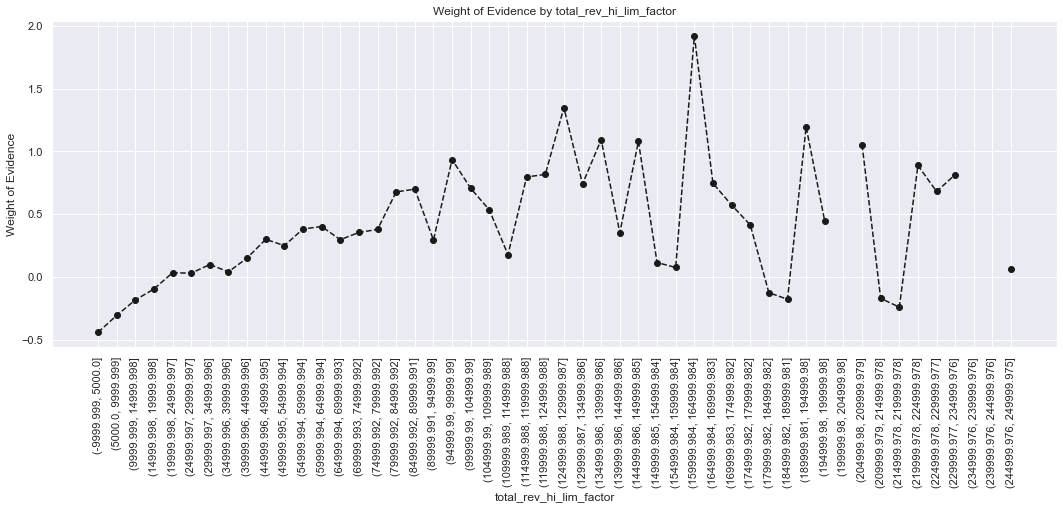

In [81]:
# total_rev_hi_lim
df_inputs_prepr['total_rev_hi_lim_factor'] = pd.cut(df_inputs_prepr['total_rev_hi_lim'], 2000)
# Here we do fine-classing: using the 'cut' method, we split the variable into 2000 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr, 'total_rev_hi_lim_factor', df_targets_prepr)
# We calculate weight of evidence.
plot_by_woe(df_temp.iloc[: 50, : ], 90)

In [82]:
# Categories
# '<=5K', '5K-10K', '10K-20K', '20K-30K', '30K-40K', '40K-55K', '55K-95K', '>95K'
df_inputs_prepr['total_rev_hi_lim:<=5K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] <= 5000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:5K-10K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 5000) &
                                                      (df_inputs_prepr['total_rev_hi_lim'] <= 10000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:10K-20K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 10000) & 
                                                       (df_inputs_prepr['total_rev_hi_lim'] <= 20000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:20K-30K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 20000) &
                                                       (df_inputs_prepr['total_rev_hi_lim'] <= 30000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:30K-40K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 30000) & 
                                                       (df_inputs_prepr['total_rev_hi_lim'] <= 40000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:40K-55K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 40000) &
                                                       (df_inputs_prepr['total_rev_hi_lim'] <= 55000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:55K-95K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 55000) & 
                                                       (df_inputs_prepr['total_rev_hi_lim'] <= 95000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:>95K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 95000), 1, 0)

<h4><a id="installment_factor_woe">7.2.14 Installment Factor</a></h4>

[Top](#continuouswoe)

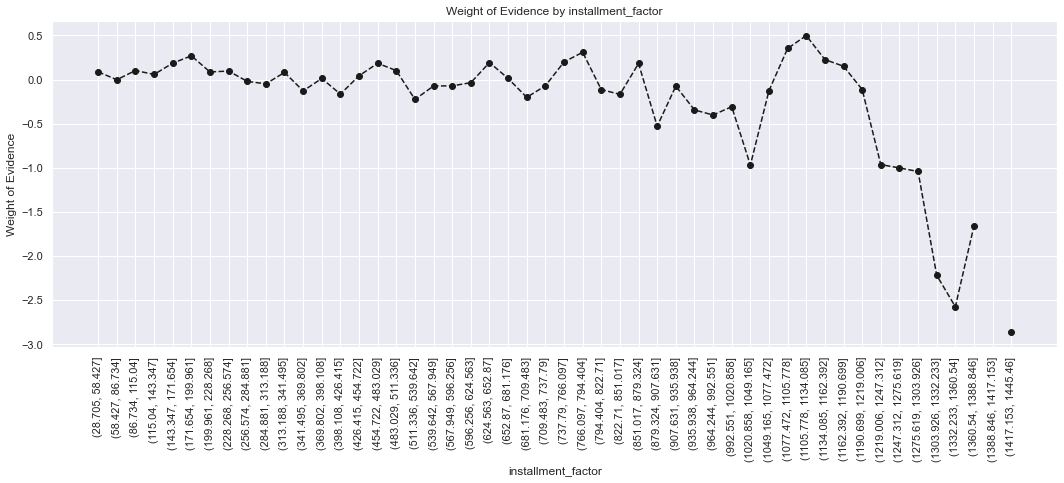

In [83]:
# installment
df_inputs_prepr['installment_factor'] = pd.cut(df_inputs_prepr['installment'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr, 'installment_factor', df_targets_prepr)
# We calculate weight of evidence.
plot_by_woe(df_temp, 90)

<h4><a id="annual_inc_factor_woe">7.2.15 Annual Income</a></h4>

[Top](#continuouswoe)

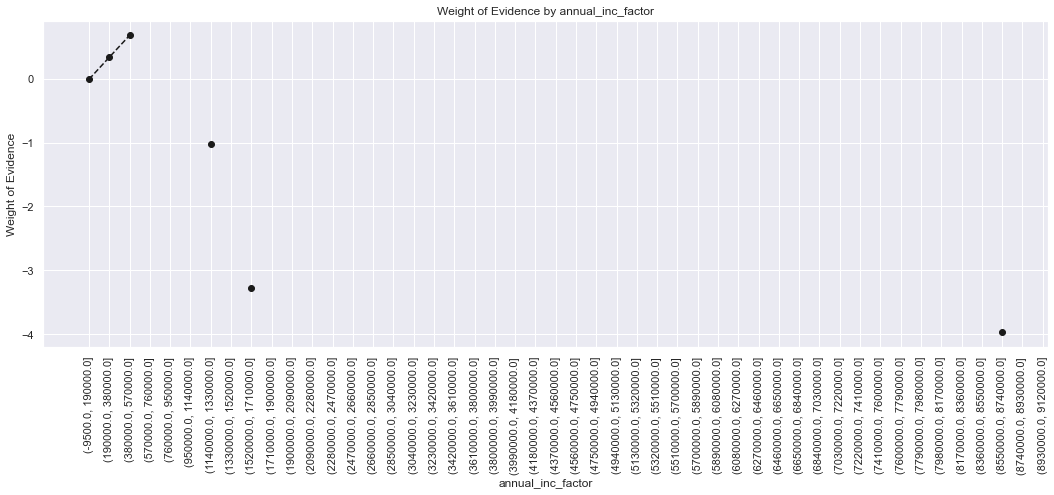

In [84]:
# annual_inc
df_inputs_prepr['annual_inc_factor'] = pd.cut(df_inputs_prepr['annual_inc'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr, 'annual_inc_factor', df_targets_prepr)
# We calculate weight of evidence.
plot_by_woe(df_temp, 90)

In [85]:
# Initial examination shows that there are too few individuals with large income and too many with small income.
# Hence, we are going to have one category for more than 150K, and we are going to apply our approach to determine
# the categories of everyone with 140k or less.
df_inputs_prepr_temp = df_inputs_prepr.loc[df_inputs_prepr['annual_inc'] <= 140000, : ]
#loan_data_temp = loan_data_temp.reset_index(drop = True)
#df_inputs_prepr_temp

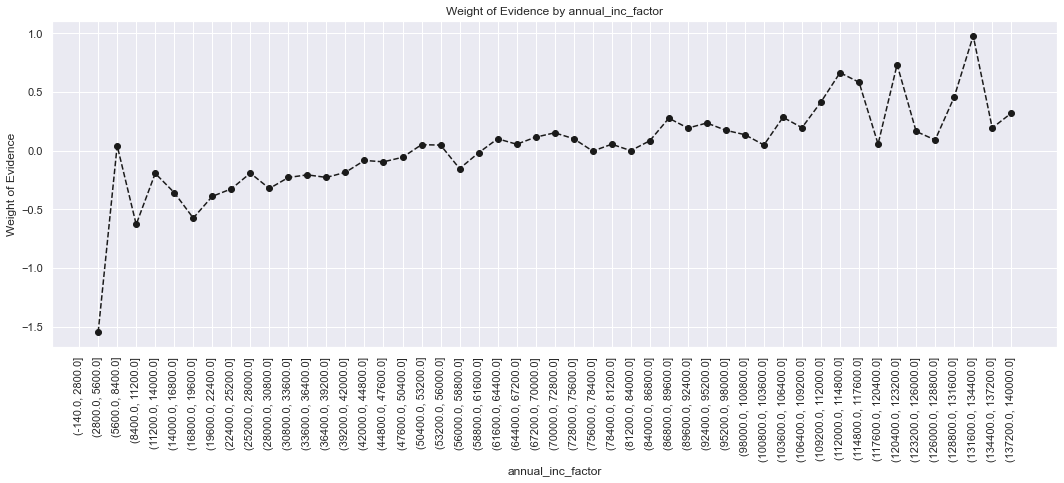

In [86]:
df_inputs_prepr_temp["annual_inc_factor"] = pd.cut(df_inputs_prepr_temp['annual_inc'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr_temp, 'annual_inc_factor', df_targets_prepr[df_inputs_prepr_temp.index])
# We calculate weight of evidence.
plot_by_woe(df_temp, 90)

In [87]:
# WoE is monotonically decreasing with income, so we split income in 10 equal categories, each with width of 15k.
df_inputs_prepr['annual_inc:<20K'] = np.where((df_inputs_prepr['annual_inc'] <= 20000), 1, 0)
df_inputs_prepr['annual_inc:20K-30K'] = np.where((df_inputs_prepr['annual_inc'] > 20000) & 
                                                 (df_inputs_prepr['annual_inc'] <= 30000), 1, 0)
df_inputs_prepr['annual_inc:30K-40K'] = np.where((df_inputs_prepr['annual_inc'] > 30000) &
                                                 (df_inputs_prepr['annual_inc'] <= 40000), 1, 0)
df_inputs_prepr['annual_inc:40K-50K'] = np.where((df_inputs_prepr['annual_inc'] > 40000) &
                                                 (df_inputs_prepr['annual_inc'] <= 50000), 1, 0)
df_inputs_prepr['annual_inc:50K-60K'] = np.where((df_inputs_prepr['annual_inc'] > 50000) &
                                                 (df_inputs_prepr['annual_inc'] <= 60000), 1, 0)
df_inputs_prepr['annual_inc:60K-70K'] = np.where((df_inputs_prepr['annual_inc'] > 60000) &
                                                 (df_inputs_prepr['annual_inc'] <= 70000), 1, 0)
df_inputs_prepr['annual_inc:70K-80K'] = np.where((df_inputs_prepr['annual_inc'] > 70000) & 
                                                 (df_inputs_prepr['annual_inc'] <= 80000), 1, 0)
df_inputs_prepr['annual_inc:80K-90K'] = np.where((df_inputs_prepr['annual_inc'] > 80000) &
                                                 (df_inputs_prepr['annual_inc'] <= 90000), 1, 0)
df_inputs_prepr['annual_inc:90K-100K'] = np.where((df_inputs_prepr['annual_inc'] > 90000) & 
                                                  (df_inputs_prepr['annual_inc'] <= 100000), 1, 0)
df_inputs_prepr['annual_inc:100K-120K'] = np.where((df_inputs_prepr['annual_inc'] > 100000) &
                                                   (df_inputs_prepr['annual_inc'] <= 120000), 1, 0)
df_inputs_prepr['annual_inc:120K-140K'] = np.where((df_inputs_prepr['annual_inc'] > 120000) & 
                                                   (df_inputs_prepr['annual_inc'] <= 140000), 1, 0)
df_inputs_prepr['annual_inc:>140K'] = np.where((df_inputs_prepr['annual_inc'] > 140000), 1, 0)

<h4><a id="mths_since_last_delinq_woe">7.2.16 Months Since Last Delinquency</a></h4>

[Top](#continuouswoe)

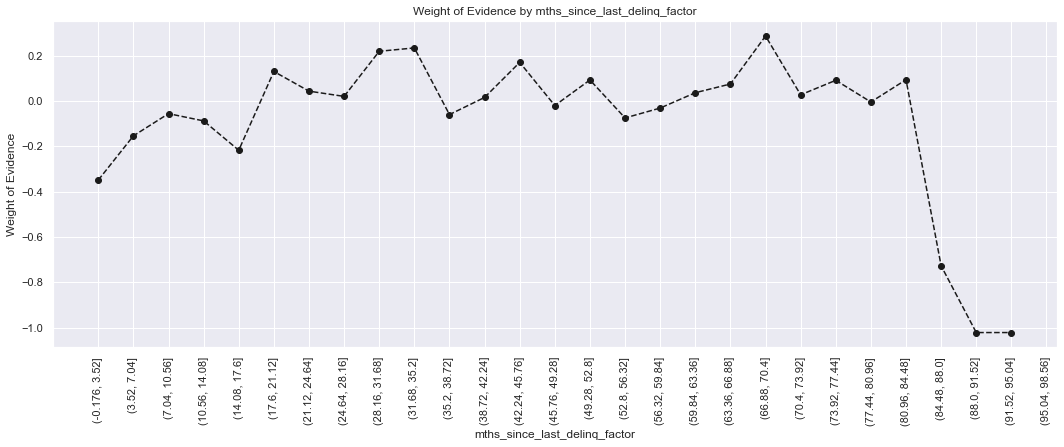

In [88]:
# mths_since_last_delinq
# We have to create one category for missing values and do fine and coarse classing for the rest.
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['mths_since_last_delinq'])]
df_inputs_prepr_temp['mths_since_last_delinq_factor'] = pd.cut(df_inputs_prepr_temp['mths_since_last_delinq'], 50)
df_temp = woe_ordered_continuous(df_inputs_prepr_temp, 'mths_since_last_delinq_factor',
                                 df_targets_prepr[df_inputs_prepr_temp.index])
# We calculate weight of evidence.
plot_by_woe(df_temp, 90)

In [89]:
# Categories: Missing, 0-3, 4-30, 31-56, >=57
df_inputs_prepr['mths_since_last_delinq:Missing'] = np.where((df_inputs_prepr['mths_since_last_delinq'].isnull()), 1, 0)
df_inputs_prepr['mths_since_last_delinq:0-3'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 0) &
                                                         (df_inputs_prepr['mths_since_last_delinq'] <= 3), 1, 0)
df_inputs_prepr['mths_since_last_delinq:4-30'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 4) & 
                                                          (df_inputs_prepr['mths_since_last_delinq'] <= 30), 1, 0)
df_inputs_prepr['mths_since_last_delinq:31-56'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 31) &
                                                           (df_inputs_prepr['mths_since_last_delinq'] <= 56), 1, 0)
df_inputs_prepr['mths_since_last_delinq:>=57'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 57), 1, 0)

<h4><a id="dti_factor_woe">7.2.17 Debt to Income Ratio</a></h4>

[Top](#continuouswoe)

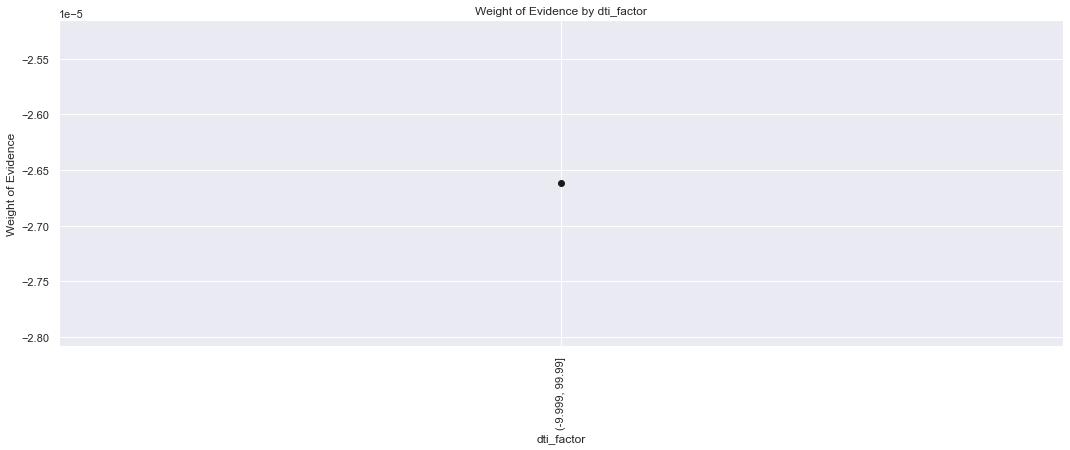

In [90]:
# dti
df_inputs_prepr['dti_factor'] = pd.cut(df_inputs_prepr['dti'], 100)
# Here we do fine-classing: using the 'cut' method, we split the variable into 100 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr, 'dti_factor', df_targets_prepr)
# We calculate weight of evidence.
plot_by_woe(df_temp, 90)

In [91]:
# Similarly to income, initial examination shows that most values are lower than 200.
# Hence, we are going to have one category for more than 35, and we are going to apply our approach to determine
# the categories of everyone with 150k or less.
df_inputs_prepr_temp = df_inputs_prepr.loc[df_inputs_prepr['dti'] <= 35, : ]

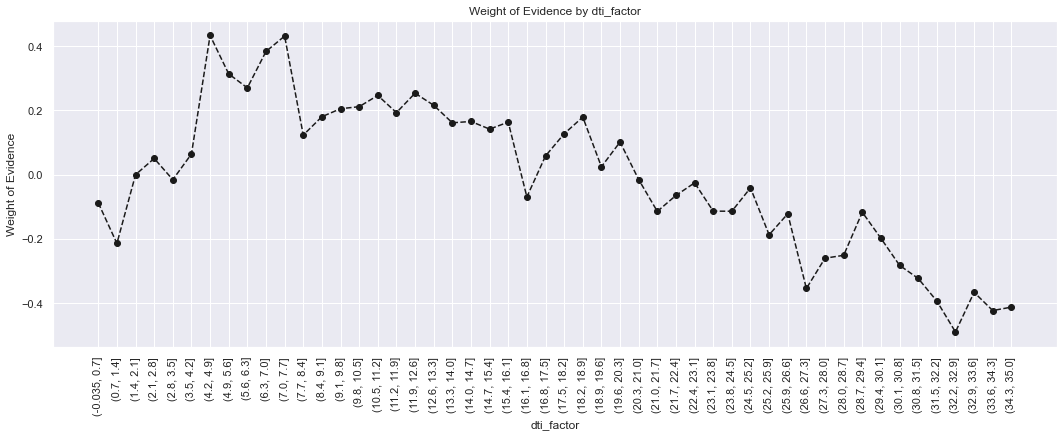

In [92]:
df_inputs_prepr_temp['dti_factor'] = pd.cut(df_inputs_prepr_temp['dti'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr_temp, 'dti_factor', df_targets_prepr[df_inputs_prepr_temp.index])
# We calculate weight of evidence.
plot_by_woe(df_temp, 90)

In [93]:
# Categories:
df_inputs_prepr['dti:<=1.4'] = np.where((df_inputs_prepr['dti'] <= 1.4), 1, 0)
df_inputs_prepr['dti:1.4-3.5'] = np.where((df_inputs_prepr['dti'] > 1.4) & (df_inputs_prepr['dti'] <= 3.5), 1, 0)
df_inputs_prepr['dti:3.5-7.7'] = np.where((df_inputs_prepr['dti'] > 3.5) & (df_inputs_prepr['dti'] <= 7.7), 1, 0)
df_inputs_prepr['dti:7.7-10.5'] = np.where((df_inputs_prepr['dti'] > 7.7) & (df_inputs_prepr['dti'] <= 10.5), 1, 0)
df_inputs_prepr['dti:10.5-16.1'] = np.where((df_inputs_prepr['dti'] > 10.5) & (df_inputs_prepr['dti'] <= 16.1), 1, 0)
df_inputs_prepr['dti:16.1-20.3'] = np.where((df_inputs_prepr['dti'] > 16.1) & (df_inputs_prepr['dti'] <= 20.3), 1, 0)
df_inputs_prepr['dti:20.3-21.7'] = np.where((df_inputs_prepr['dti'] > 20.3) & (df_inputs_prepr['dti'] <= 21.7), 1, 0)
df_inputs_prepr['dti:21.7-22.4'] = np.where((df_inputs_prepr['dti'] > 21.7) & (df_inputs_prepr['dti'] <= 22.4), 1, 0)
df_inputs_prepr['dti:22.4-35'] = np.where((df_inputs_prepr['dti'] > 22.4) & (df_inputs_prepr['dti'] <= 35), 1, 0)
df_inputs_prepr['dti:>35'] = np.where((df_inputs_prepr['dti'] > 35), 1, 0)

<h4><a id="mths_since_last_record_woe">7.2.18 Months Since Last Record</a></h4>

[Top](#continuouswoe)

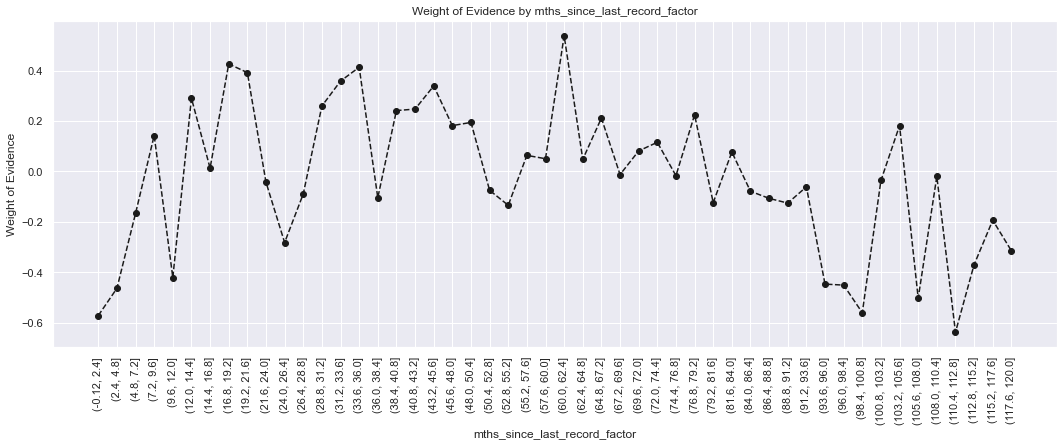

In [94]:
# mths_since_last_record
# We have to create one category for missing values and do fine and coarse classing for the rest.
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['mths_since_last_record'])]
#sum(loan_data_temp['mths_since_last_record'].isnull())
df_inputs_prepr_temp['mths_since_last_record_factor'] = pd.cut(df_inputs_prepr_temp['mths_since_last_record'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr_temp, 'mths_since_last_record_factor', 
                                 df_targets_prepr[df_inputs_prepr_temp.index])
# We calculate weight of evidence.
plot_by_woe(df_temp, 90)

In [95]:
# Categories: 'Missing', '0-2', '3-20', '21-31', '32-80', '81-86', '>86'
df_inputs_prepr['mths_since_last_record:Missing'] = np.where((df_inputs_prepr['mths_since_last_record'].isnull()), 1, 0)
df_inputs_prepr['mths_since_last_record:0-2'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 0) & 
                                                         (df_inputs_prepr['mths_since_last_record'] <= 2), 1, 0)
df_inputs_prepr['mths_since_last_record:3-20'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 3) &
                                                          (df_inputs_prepr['mths_since_last_record'] <= 20), 1, 0)
df_inputs_prepr['mths_since_last_record:21-31'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 21) & 
                                                           (df_inputs_prepr['mths_since_last_record'] <= 31), 1, 0)
df_inputs_prepr['mths_since_last_record:32-80'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 32) &
                                                           (df_inputs_prepr['mths_since_last_record'] <= 80), 1, 0)
df_inputs_prepr['mths_since_last_record:81-86'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 81) & 
                                                           (df_inputs_prepr['mths_since_last_record'] <= 86), 1, 0)
df_inputs_prepr['mths_since_last_record:>86'] = np.where((df_inputs_prepr['mths_since_last_record'] > 86), 1, 0)

<h2><a id="exportdata">8. Export to CSV File</a></h2>

[Index](#index)

In [96]:
loan_data_inputs_2015 = df_inputs_prepr
loan_data_targets_2015 = df_targets_prepr

In [97]:
print(f"Shape X: {loan_data_inputs_2015.shape}")
print(f"Shape y: {loan_data_targets_2015.shape}")

Shape X: (421094, 320)
Shape y: (421094,)


In [98]:
loan_data_inputs_2015.to_csv('../Data/loan_data_inputs_2015.csv')
loan_data_targets_2015.to_csv('../Data/loan_data_targets_2015.csv')

<h2><a id="scorenewdata">9. Score New Data</a></h2>

[Index](#index)

In [99]:
inputs_train_with_ref_cat = pd.read_csv('..//Data//inputs_train_with_ref_cat.csv', index_col = 0)
# We import the dataset with old data, i.e. "expected" data.

In [100]:
# Here we select a limited set of input variables in a new dataframe.
selected_features = ['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F', 'grade:G', 
                     'home_ownership:RENT_OTHER_NONE_ANY', 'home_ownership:OWN', 'home_ownership:MORTGAGE', 
                     'addr_state:ND_NE_IA_NV_FL_HI_AL', 'addr_state:NM_VA', 'addr_state:NY', 
                     'addr_state:OK_TN_MO_LA_MD_NC', 'addr_state:CA', 'addr_state:UT_KY_AZ_NJ', 
                     'addr_state:AR_MI_PA_OH_MN', 'addr_state:RI_MA_DE_SD_IN', 'addr_state:GA_WA_OR', 'addr_state:WI_MT',
                     'addr_state:TX', 'addr_state:IL_CT', 'addr_state:KS_SC_CO_VT_AK_MS', 'addr_state:WV_NH_WY_DC_ME_ID', 
                     'verification_status:Not Verified', 'verification_status:Source Verified', 
                     'verification_status:Verified', 
                     'purpose:educ__sm_b__wedd__ren_en__mov__house', 'purpose:credit_card', 'purpose:debt_consolidation', 
                     'purpose:oth__med__vacation', 'purpose:major_purch__car__home_impr', 
                     'initial_list_status:f', 'initial_list_status:w', 
                     'term:36', 'term:60',
                     'emp_length:0', 'emp_length:1', 'emp_length:2-4', 'emp_length:5-6', 'emp_length:7-9', 
                     'emp_length:10', 
                     'mths_since_issue_d:<38', 'mths_since_issue_d:38-39', 'mths_since_issue_d:40-41', 
                     'mths_since_issue_d:42-48', 'mths_since_issue_d:49-52', 'mths_since_issue_d:53-64', 
                     'mths_since_issue_d:65-84', 'mths_since_issue_d:>84',
                     'int_rate:<9.548', 'int_rate:9.548-12.025', 'int_rate:12.025-15.74', 'int_rate:15.74-20.281', 
                     'int_rate:>20.281',
                     'mths_since_earliest_cr_line:<140', 'mths_since_earliest_cr_line:141-164',
                     'mths_since_earliest_cr_line:165-247', 'mths_since_earliest_cr_line:248-270', 
                     'mths_since_earliest_cr_line:271-352', 'mths_since_earliest_cr_line:>352',
                     'delinq_2yrs:0', 'delinq_2yrs:1-3', 'delinq_2yrs:>=4',
                     'inq_last_6mths:0', 'inq_last_6mths:1-2', 'inq_last_6mths:3-6', 'inq_last_6mths:>6', 
                     'open_acc:0', 'open_acc:1-3', 'open_acc:4-12', 'open_acc:13-17', 'open_acc:18-22', 'open_acc:23-25', 
                     'open_acc:26-30', 'open_acc:>=31', 
                     'pub_rec:0-2', 'pub_rec:3-4', 'pub_rec:>=5',
                     'total_acc:<=27', 'total_acc:28-51', 'total_acc:>=52', 
                     'acc_now_delinq:0', 'acc_now_delinq:>=1', 
                     'total_rev_hi_lim:<=5K', 'total_rev_hi_lim:5K-10K', 'total_rev_hi_lim:10K-20K', 
                     'total_rev_hi_lim:20K-30K', 'total_rev_hi_lim:30K-40K', 'total_rev_hi_lim:40K-55K', 
                     'total_rev_hi_lim:55K-95K', 'total_rev_hi_lim:>95K', 
                     'annual_inc:<20K', 'annual_inc:20K-30K', 'annual_inc:30K-40K', 'annual_inc:40K-50K', 
                     'annual_inc:50K-60K', 'annual_inc:60K-70K', 'annual_inc:70K-80K', 'annual_inc:80K-90K', 
                     'annual_inc:90K-100K', 'annual_inc:100K-120K', 'annual_inc:120K-140K', 'annual_inc:>140K', 
                     'dti:<=1.4', 'dti:1.4-3.5', 'dti:3.5-7.7', 'dti:7.7-10.5', 'dti:10.5-16.1', 'dti:16.1-20.3', 
                     'dti:20.3-21.7', 'dti:21.7-22.4', 'dti:22.4-35', 'dti:>35', 
                     'mths_since_last_delinq:Missing', 'mths_since_last_delinq:0-3', 'mths_since_last_delinq:4-30', 
                     'mths_since_last_delinq:31-56', 'mths_since_last_delinq:>=57', 'mths_since_last_record:Missing', 
                     'mths_since_last_record:0-2', 'mths_since_last_record:3-20', 'mths_since_last_record:21-31', 
                     'mths_since_last_record:32-80',  'mths_since_last_record:81-86', 'mths_since_last_record:>86',]

In [101]:
# Here we store the names of the reference category dummy variables in a list.
ref_categories = ['grade:G', 'home_ownership:RENT_OTHER_NONE_ANY', 'addr_state:ND_NE_IA_NV_FL_HI_AL', 
                  'verification_status:Verified',  'purpose:educ__sm_b__wedd__ren_en__mov__house', 
                  'initial_list_status:f', 'term:60', 'emp_length:0', 'mths_since_issue_d:>84', 
                  'int_rate:>20.281', 'mths_since_earliest_cr_line:<140', 'delinq_2yrs:>=4', 'inq_last_6mths:>6', 
                  'open_acc:0', 'pub_rec:0-2', 'total_acc:<=27', 'acc_now_delinq:0', 'total_rev_hi_lim:<=5K', 
                  'annual_inc:<20K', 'dti:>35', 'mths_since_last_delinq:0-3', 'mths_since_last_record:0-2']

In [102]:
inputs_2015_with_ref_cat = loan_data_inputs_2015[selected_features]
#inputs_2015_with_ref_cat = inputs_2015_with_ref_cat.drop(ref_categories, axis=1)

In [103]:
print(f"Train Data X Shape: {inputs_train_with_ref_cat.shape}")
print(f"Test Data X Shape: {inputs_2015_with_ref_cat.shape}")

Train Data X Shape: (373028, 126)
Test Data X Shape: (421094, 126)


In [104]:
# We import the scorecard.
df_scorecard = pd.read_csv('../Data/df_scorecard.csv', index_col = 0)
df_scorecard.head()

,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation,Score - Preliminary,Difference,Score - Final
0,0,Intercept,-1.374022,NaN,Intercept,312.690576,313.0,0.309424,313.0
1,1,grade:A,1.123667,3.224492e-35,grade,86.693359,87.0,0.306641,87.0
2,2,grade:B,0.878915,4.281595e-47,grade,67.810233,68.0,0.189767,68.0
3,3,grade:C,0.684794,6.716246e-34,grade,52.833329,53.0,0.166671,53.0
4,4,grade:D,0.496922,1.347121e-20,grade,38.338645,38.0,-0.338645,38.0


In [105]:
# We insert a column in the dataframe, with an index of 0, that is, in the beginning of the dataframe.
# The name of that column is 'Intercept', and its values are 1s.
inputs_train_with_ref_cat_w_intercept = inputs_train_with_ref_cat
inputs_train_with_ref_cat_w_intercept.insert(0, 'Intercept', 1)

# Here, from the 'inputs_train_with_ref_cat_w_intercept' dataframe, we keep only the columns with column names,
# exactly equal to the row values of the 'Feature name' column from the 'df_scorecard' dataframe.
inputs_train_with_ref_cat_w_intercept = inputs_train_with_ref_cat_w_intercept[df_scorecard['Feature name'].values]

inputs_train_with_ref_cat_w_intercept.head()

,Intercept,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NM_VA,addr_state:NY,addr_state:OK_TN_MO_LA_MD_NC,addr_state:CA,addr_state:UT_KY_AZ_NJ,addr_state:AR_MI_PA_OH_MN,addr_state:RI_MA_DE_SD_IN,addr_state:GA_WA_OR,addr_state:WI_MT,addr_state:TX,addr_state:IL_CT,addr_state:KS_SC_CO_VT_AK_MS,addr_state:WV_NH_WY_DC_ME_ID,verification_status:Not Verified,verification_status:Source Verified,purpose:credit_card,purpose:debt_consolidation,purpose:oth__med__vacation,purpose:major_purch__car__home_impr,initial_list_status:w,term:36,emp_length:1,emp_length:2-4,emp_length:5-6,emp_length:7-9,emp_length:10,mths_since_issue_d:<38,mths_since_issue_d:38-39,mths_since_issue_d:40-41,mths_since_issue_d:42-48,mths_since_issue_d:49-52,mths_since_issue_d:53-64,mths_since_issue_d:65-84,int_rate:<9.548,int_rate:9.548-12.025,int_rate:12.025-15.74,int_rate:15.74-20.281,mths_since_earliest_cr_line:141-164,mths_since_earliest_cr_line:165-247,mths_since_earliest_cr_line:248-270,mths_since_earliest_cr_line:271-352,mths_since_earliest_cr_line:>352,inq_last_6mths:0,inq_last_6mths:1-2,inq_last_6mths:3-6,acc_now_delinq:>=1,annual_inc:20K-30K,annual_inc:30K-40K,annual_inc:40K-50K,annual_inc:50K-60K,annual_inc:60K-70K,annual_inc:70K-80K,annual_inc:80K-90K,annual_inc:90K-100K,annual_inc:100K-120K,annual_inc:120K-140K,annual_inc:>140K,dti:<=1.4,dti:1.4-3.5,dti:3.5-7.7,dti:7.7-10.5,dti:10.5-16.1,dti:16.1-20.3,dti:20.3-21.7,dti:21.7-22.4,dti:22.4-35,mths_since_last_delinq:Missing,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86,grade:G,home_ownership:RENT_OTHER_NONE_ANY,addr_state:ND_NE_IA_NV_FL_HI_AL,verification_status:Verified,purpose:educ__sm_b__wedd__ren_en__mov__house,initial_list_status:f,term:60,emp_length:0,mths_since_issue_d:>84,int_rate:>20.281,mths_since_earliest_cr_line:<140,inq_last_6mths:>6,acc_now_delinq:0,annual_inc:<20K,dti:>35,mths_since_last_delinq:0-3,mths_since_last_record:0-2
427211,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
206088,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
136020,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0
412305,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
36159,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,1,0,0,0,0


In [106]:
# We insert a column in the dataframe, with an index of 0, that is, in the beginning of the dataframe.
# The name of that column is 'Intercept', and its values are 1s.
inputs_2015_with_ref_cat_w_intercept = inputs_2015_with_ref_cat
inputs_2015_with_ref_cat_w_intercept.insert(0, 'Intercept', 1)

# Here, from the 'inputs_train_with_ref_cat_w_intercept' dataframe, we keep only the columns with column names,
# exactly equal to the row values of the 'Feature name' column from the 'df_scorecard' dataframe.
inputs_2015_with_ref_cat_w_intercept = inputs_2015_with_ref_cat_w_intercept[df_scorecard['Feature name'].values]

inputs_2015_with_ref_cat_w_intercept.head()

,Intercept,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NM_VA,addr_state:NY,addr_state:OK_TN_MO_LA_MD_NC,addr_state:CA,addr_state:UT_KY_AZ_NJ,addr_state:AR_MI_PA_OH_MN,addr_state:RI_MA_DE_SD_IN,addr_state:GA_WA_OR,addr_state:WI_MT,addr_state:TX,addr_state:IL_CT,addr_state:KS_SC_CO_VT_AK_MS,addr_state:WV_NH_WY_DC_ME_ID,verification_status:Not Verified,verification_status:Source Verified,purpose:credit_card,purpose:debt_consolidation,purpose:oth__med__vacation,purpose:major_purch__car__home_impr,initial_list_status:w,term:36,emp_length:1,emp_length:2-4,emp_length:5-6,emp_length:7-9,emp_length:10,mths_since_issue_d:<38,mths_since_issue_d:38-39,mths_since_issue_d:40-41,mths_since_issue_d:42-48,mths_since_issue_d:49-52,mths_since_issue_d:53-64,mths_since_issue_d:65-84,int_rate:<9.548,int_rate:9.548-12.025,int_rate:12.025-15.74,int_rate:15.74-20.281,mths_since_earliest_cr_line:141-164,mths_since_earliest_cr_line:165-247,mths_since_earliest_cr_line:248-270,mths_since_earliest_cr_line:271-352,mths_since_earliest_cr_line:>352,inq_last_6mths:0,inq_last_6mths:1-2,inq_last_6mths:3-6,acc_now_delinq:>=1,annual_inc:20K-30K,annual_inc:30K-40K,annual_inc:40K-50K,annual_inc:50K-60K,annual_inc:60K-70K,annual_inc:70K-80K,annual_inc:80K-90K,annual_inc:90K-100K,annual_inc:100K-120K,annual_inc:120K-140K,annual_inc:>140K,dti:<=1.4,dti:1.4-3.5,dti:3.5-7.7,dti:7.7-10.5,dti:10.5-16.1,dti:16.1-20.3,dti:20.3-21.7,dti:21.7-22.4,dti:22.4-35,mths_since_last_delinq:Missing,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86,grade:G,home_ownership:RENT_OTHER_NONE_ANY,addr_state:ND_NE_IA_NV_FL_HI_AL,verification_status:Verified,purpose:educ__sm_b__wedd__ren_en__mov__house,initial_list_status:f,term:60,emp_length:0,mths_since_issue_d:>84,int_rate:>20.281,mths_since_earliest_cr_line:<140,inq_last_6mths:>6,acc_now_delinq:0,annual_inc:<20K,dti:>35,mths_since_last_delinq:0-3,mths_since_last_record:0-2
0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
3,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


In [107]:
scorecard_scores = df_scorecard['Score - Final']
scorecard_scores = scorecard_scores.values.reshape(102, 1)

In [108]:
# Here we multiply the values of each row of the dataframe by the values of each column of the variable,
# which is an argument of the 'dot' method, and sum them. It's essentially the sum of the products.
y_scores_train = inputs_train_with_ref_cat_w_intercept.dot(scorecard_scores)
y_scores_train.head()

,0
427211,689.0
206088,597.0
136020,671.0
412305,526.0
36159,527.0


In [109]:
# Here we multiply the values of each row of the dataframe by the values of each column of the variable,
# which is an argument of the 'dot' method, and sum them. It's essentially the sum of the products.
y_scores_2015 = inputs_2015_with_ref_cat_w_intercept.dot(scorecard_scores)
y_scores_2015.head()

,0
0,749.0
1,756.0
2,635.0
3,624.0
4,702.0


In [110]:
# Here we concatenate the scores we calculated with the rest of the variables in the two dataframes:
# the one with old ("expected") data and the one with new ("actual") data.
inputs_train_with_ref_cat_w_intercept = pd.concat([inputs_train_with_ref_cat_w_intercept, y_scores_train], axis = 1)

inputs_2015_with_ref_cat_w_intercept = pd.concat([inputs_2015_with_ref_cat_w_intercept, y_scores_2015], axis = 1)

In [111]:
# Here we rename the columns containing scores to "Score" in both dataframes.
inputs_train_with_ref_cat_w_intercept.columns.values[inputs_train_with_ref_cat_w_intercept.shape[1] - 1] = 'Score'
inputs_2015_with_ref_cat_w_intercept.columns.values[inputs_2015_with_ref_cat_w_intercept.shape[1] - 1] = 'Score'

inputs_2015_with_ref_cat_w_intercept.head()

,Intercept,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NM_VA,addr_state:NY,addr_state:OK_TN_MO_LA_MD_NC,addr_state:CA,addr_state:UT_KY_AZ_NJ,addr_state:AR_MI_PA_OH_MN,addr_state:RI_MA_DE_SD_IN,addr_state:GA_WA_OR,addr_state:WI_MT,addr_state:TX,addr_state:IL_CT,addr_state:KS_SC_CO_VT_AK_MS,addr_state:WV_NH_WY_DC_ME_ID,verification_status:Not Verified,verification_status:Source Verified,purpose:credit_card,purpose:debt_consolidation,purpose:oth__med__vacation,purpose:major_purch__car__home_impr,initial_list_status:w,term:36,emp_length:1,emp_length:2-4,emp_length:5-6,emp_length:7-9,emp_length:10,mths_since_issue_d:<38,mths_since_issue_d:38-39,mths_since_issue_d:40-41,mths_since_issue_d:42-48,mths_since_issue_d:49-52,mths_since_issue_d:53-64,mths_since_issue_d:65-84,int_rate:<9.548,int_rate:9.548-12.025,int_rate:12.025-15.74,int_rate:15.74-20.281,mths_since_earliest_cr_line:141-164,mths_since_earliest_cr_line:165-247,mths_since_earliest_cr_line:248-270,mths_since_earliest_cr_line:271-352,mths_since_earliest_cr_line:>352,inq_last_6mths:0,inq_last_6mths:1-2,inq_last_6mths:3-6,acc_now_delinq:>=1,annual_inc:20K-30K,annual_inc:30K-40K,annual_inc:40K-50K,annual_inc:50K-60K,annual_inc:60K-70K,annual_inc:70K-80K,annual_inc:80K-90K,annual_inc:90K-100K,annual_inc:100K-120K,annual_inc:120K-140K,annual_inc:>140K,dti:<=1.4,dti:1.4-3.5,dti:3.5-7.7,dti:7.7-10.5,dti:10.5-16.1,dti:16.1-20.3,dti:20.3-21.7,dti:21.7-22.4,dti:22.4-35,mths_since_last_delinq:Missing,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86,grade:G,home_ownership:RENT_OTHER_NONE_ANY,addr_state:ND_NE_IA_NV_FL_HI_AL,verification_status:Verified,purpose:educ__sm_b__wedd__ren_en__mov__house,initial_list_status:f,term:60,emp_length:0,mths_since_issue_d:>84,int_rate:>20.281,mths_since_earliest_cr_line:<140,inq_last_6mths:>6,acc_now_delinq:0,annual_inc:<20K,dti:>35,mths_since_last_delinq:0-3,mths_since_last_record:0-2,Score
0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,749.0
1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,756.0
2,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,635.0
3,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,624.0
4,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,702.0


In [112]:
inputs_train_with_ref_cat_w_intercept['Score:300-350'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 300)
                                                                  & (inputs_train_with_ref_cat_w_intercept['Score'] < 350),
                                                                  1, 0)
inputs_train_with_ref_cat_w_intercept['Score:350-400'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 350) 
                                                                  & (inputs_train_with_ref_cat_w_intercept['Score'] < 400),
                                                                  1, 0)
inputs_train_with_ref_cat_w_intercept['Score:400-450'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 400)
                                                                  & (inputs_train_with_ref_cat_w_intercept['Score'] < 450),
                                                                  1, 0)
inputs_train_with_ref_cat_w_intercept['Score:450-500'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 450)
                                                                  & (inputs_train_with_ref_cat_w_intercept['Score'] < 500),
                                                                  1, 0)
inputs_train_with_ref_cat_w_intercept['Score:500-550'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 500)
                                                                  & (inputs_train_with_ref_cat_w_intercept['Score'] < 550),
                                                                  1, 0)
inputs_train_with_ref_cat_w_intercept['Score:550-600'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 550)
                                                                  & (inputs_train_with_ref_cat_w_intercept['Score'] < 600),
                                                                  1, 0)
inputs_train_with_ref_cat_w_intercept['Score:600-650'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 600)
                                                                  & (inputs_train_with_ref_cat_w_intercept['Score'] < 650),
                                                                  1, 0)
inputs_train_with_ref_cat_w_intercept['Score:650-700'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 650)
                                                                  & (inputs_train_with_ref_cat_w_intercept['Score'] < 700),
                                                                  1, 0)
inputs_train_with_ref_cat_w_intercept['Score:700-750'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 700)
                                                                  & (inputs_train_with_ref_cat_w_intercept['Score'] < 750),
                                                                  1, 0)
inputs_train_with_ref_cat_w_intercept['Score:750-800'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 750)
                                                                  & (inputs_train_with_ref_cat_w_intercept['Score'] < 800),
                                                                  1, 0)
inputs_train_with_ref_cat_w_intercept['Score:800-850'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 800)
                                                                  & (inputs_train_with_ref_cat_w_intercept['Score'] <= 850)
                                                                  , 1, 0)
# We create dummy variables for score intervals in the dataframe with old ("expected").

In [113]:
inputs_2015_with_ref_cat_w_intercept['Score:300-350'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 300)
                                                                 & (inputs_2015_with_ref_cat_w_intercept['Score'] < 350),
                                                                 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:350-400'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 350)
                                                                 & (inputs_2015_with_ref_cat_w_intercept['Score'] < 400),
                                                                 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:400-450'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 400)
                                                                 & (inputs_2015_with_ref_cat_w_intercept['Score'] < 450),
                                                                 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:450-500'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 450)
                                                                 & (inputs_2015_with_ref_cat_w_intercept['Score'] < 500),
                                                                 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:500-550'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 500)
                                                                 & (inputs_2015_with_ref_cat_w_intercept['Score'] < 550),
                                                                 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:550-600'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 550)
                                                                 & (inputs_2015_with_ref_cat_w_intercept['Score'] < 600),
                                                                 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:600-650'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 600)
                                                                 & (inputs_2015_with_ref_cat_w_intercept['Score'] < 650),
                                                                 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:650-700'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 650)
                                                                 & (inputs_2015_with_ref_cat_w_intercept['Score'] < 700),
                                                                 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:700-750'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 700)
                                                                 & (inputs_2015_with_ref_cat_w_intercept['Score'] < 750),
                                                                 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:750-800'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 750)
                                                                 & (inputs_2015_with_ref_cat_w_intercept['Score'] < 800),
                                                                 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:800-850'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 800)
                                                                 & (inputs_2015_with_ref_cat_w_intercept['Score'] <= 850),
                                                                 1, 0)
# We create dummy variables for score intervals in the dataframe with new ("actual").

<h2><a id="psicalc">10. PSI Calculations</a></h2>

[Index](#index)

In [114]:
# We create a dataframe with proportions of observations for each dummy variable for the old ("expected") data.
PSI_calc_train = inputs_train_with_ref_cat_w_intercept.sum() / inputs_train_with_ref_cat_w_intercept.shape[0]

In [115]:
# We create a dataframe with proportions of observations for each dummy variable for the new ("actual") data.
PSI_calc_2015 = inputs_2015_with_ref_cat_w_intercept.sum() / inputs_2015_with_ref_cat_w_intercept.shape[0]

In [116]:
# We concatenate the two dataframes along the columns.
PSI_calc = pd.concat([PSI_calc_train, PSI_calc_2015], axis = 1)

In [117]:
# We reset the index of the dataframe. The index becomes from 0 to the total number of rows less one.
# The old index, which is the dummy variable name, becomes a column, named 'index'.
PSI_calc = PSI_calc.reset_index()

# We create a new column, called 'Original feature name', which contains the value of the 'Feature name' column,
# up to the column symbol.
PSI_calc['Original feature name'] = PSI_calc['index'].str.split(':').str[0]

# We change the names of the columns of the dataframe.
PSI_calc.columns = ['index', 'Proportions_Train', 'Proportions_New', 'Original feature name']

In [118]:
PSI_calc = PSI_calc[np.array(['index', 'Original feature name', 'Proportions_Train', 'Proportions_New'])]
PSI_calc.head()

,index,Original feature name,Proportions_Train,Proportions_New
0,Intercept,Intercept,1.000000,1.000000
1,grade:A,grade,0.160200,0.174154
2,grade:B,grade,0.294160,0.279287
3,grade:C,grade,0.268733,0.286318
4,grade:D,grade,0.164862,0.148789


In [119]:
# We remove the rows with values in the 'index' column 'Intercept' and 'Score'.
PSI_calc = PSI_calc[(PSI_calc['index'] != 'Intercept') & (PSI_calc['index'] != 'Score')]

In [120]:
# We calculate the contribution of each dummy variable to the PSI of each original variable it comes from.
# If either the proportion of old data or the proportion of new data are 0, the contribution is 0.
# Otherwise, we apply the PSI formula for each contribution.
PSI_calc['Contribution'] = np.where((PSI_calc['Proportions_Train'] == 0) | (PSI_calc['Proportions_New'] == 0), 0, 
                                    (PSI_calc['Proportions_New'] - PSI_calc['Proportions_Train']) * np.log(
                                        PSI_calc['Proportions_New'] / PSI_calc['Proportions_Train']))
PSI_calc.head()

,index,Original feature name,Proportions_Train,Proportions_New,Contribution
1,grade:A,grade,0.160200,0.174154,0.001165
2,grade:B,grade,0.294160,0.279287,0.000772
3,grade:C,grade,0.268733,0.286318,0.001115
4,grade:D,grade,0.164862,0.148789,0.001649
5,grade:E,grade,0.076702,0.082993,0.000496


In [121]:
# Finally, we sum all contributions for each original independent variable and the 'Score' variable.
PSI_calc.groupby('Original feature name')['Contribution'].sum()

Original feature name
Score                          0.300926
acc_now_delinq                 0.000925
addr_state                     0.003837
annual_inc                     0.005445
dti                            0.078143
emp_length                     0.007619
grade                          0.006775
home_ownership                 0.004275
initial_list_status            0.333717
inq_last_6mths                 0.046465
int_rate                       0.079230
mths_since_earliest_cr_line    0.003603
mths_since_issue_d             0.304788
mths_since_last_delinq         0.011594
mths_since_last_record         0.056276
purpose                        0.011645
term                           0.013099
verification_status            0.048219
Name: Contribution, dtype: float64